# Introduction to Causal Inference with Probabilistic Programming Languages

Causal inference asks a deceptively simple question: *"What would have happened if things were
different?"* Whether we're evaluating a job training program, testing a new medical treatment,
or analyzing the impact of a policy change, we want to understand the causal effect of an
intervention—not just observe correlations in the data.

Traditional statistical methods often struggle with causal questions because they conflate
correlation with causation. When confounders—variables that affect both treatment assignment
and outcomes—are present, naive comparisons can lead us astray. This notebook demonstrates how
**probabilistic programming languages (PPLs)** provide a powerful framework for causal inference
that makes confounding explicit, quantifies uncertainty properly, and enables us to answer
counterfactual questions directly.

## Why Probabilistic Programming Languages?

**Probabilistic Programming Languages (PPLs)** like NumPyro, PyMC, and Stan offer several
compelling advantages for causal inference:

1. **Express causal models naturally**: We can explicitly model both the treatment assignment
   mechanism and the outcome process, making confounding relationships transparent in our code.
   This aligns perfectly with Pearl's structural causal models and the backdoor criterion.

2. **Quantify uncertainty rigorously**: Bayesian inference gives us full posterior distributions,
   not just point estimates. We get credible intervals that properly account for all sources of
   uncertainty, from parameter estimation to model specification.

3. **Implement the `do` operator directly**: PPLs let us implement Pearl's do-calculus naturally,
   allowing us to compute counterfactuals ("what if everyone received treatment?") by simply
   conditioning on interventions rather than observations.

4. **Flexible modeling without sacrificing interpretability**: We can use non-linear models,
   hierarchical structures, and other sophisticated approaches while maintaining clear causal
   interpretability. The same framework works for simple linear models and complex hierarchical
   designs.

## How can notebook help you?

Through hands-on examples, this notebook will guide you through the process of building causal models using PPLs. Concretely:

- **Build causal models** that explicitly account for confounders using both linear and
  generalized linear models
- **Estimate the Average Treatment Effect (ATE)** using Bayesian inference, complete with
  uncertainty quantification
- **Compare naive vs. adjusted estimates** to see firsthand how confounding can bias results
- **Use the `do` operator** to compute counterfactual outcomes and estimate causal effects
- **Validate models rigorously** using prior predictive checks, convergence diagnostics, and
  posterior predictive checks
- **Compare model specifications** to understand when more sophisticated models (like GLMs) improve
  upon simpler approaches

## The Lalonde Dataset

We'll work with the famous [Lalonde dataset](https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html)
which studies the effect of a job training program on earnings. This dataset is a classic in causal inference because it vividly demonstrates how
naive comparisons can be misleading when confounders are present. The treated and control groups
differ systematically in pre-treatment characteristics (age, education, prior earnings, etc.),
making a simple comparison of means unreliable. By properly adjusting for these confounders, we
can uncover the true causal effect of the training program.

**Reference**: Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

## Approach

This notebook reproduces and extends the approach from [ChiRho's backdoor adjustment tutorial](https://basisresearch.github.io/chirho/backdoor.html),
implementing the same causal modeling strategy using [PyMC](https://docs.pymc.io/en/stable/).
We'll build models step-by-step, validate them thoroughly, and compare different estimation
approaches to build intuition for causal inference with probabilistic programming.

This approach is very similar to the one presented in the great blog post [Causal inference with gamma regression or: The problem is with the link function,
not the likelihood (Part 6 of the GLM and causal inference series.)](https://solomonkurz.netlify.app/blog/2023-05-14-causal-inference-with-gamma-regression-or-the-problem-is-with-the-link-function-not-the-likelihood/). Tha main difference, is that we rely on PyMC and the `do` operator to compute counterfactuals.

**Remark:** [Solomon Kurz](https://solomonkurz.netlify.app/)'s blog is a fantastic resource to learn about Bayesian methods and causal inference(he mainly uses Stan and `brms`).


## Prepare Notebook

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pymc.model.transform.conditioning import do, observe
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

seed: int = 42
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Read and Preprocess Data

We load the data and preprocess it following the same approach as the original tutorial,
preparing it for use in our causal models.

In [2]:
data_path = "https://raw.githubusercontent.com/rugg2/rugg2.github.io/master/lalonde.csv"
data = pd.read_csv(data_path)


# Convert the data to the right format
data["re75"] = data["re75"] / 1_000
# Add a small constant to avoid log(0) in the model
data["re78"] = data["re78"] / 1_000 + 1e-6
data = data.rename(columns={"educ": "education", "hispan": "hispanic"})

# Define the covariates
covariates_names = [
    "education",
    "age",
    "re75",
    "black",
    "hispanic",
    "married",
    "nodegree",
]

# Extract treatment, covariates and earnings from the dataframe
df = data[["treat", *covariates_names, "re78"]]

n_obs = df.shape[0]

df.head()

treat  education  age  re75  black  hispanic  married  nodegree       re78
0      1         11   37   0.0      1         0        1         1   9.930047
1      1          9   22   0.0      0         1        0         1   3.595895
2      1         12   30   0.0      1         0        0         0  24.909451
3      1         11   27   0.0      1         0        0         1   7.506147
4      1          8   33   0.0      1         0        0         1   0.289791

### Understanding the Data Structure

The following are the main feature groups in the dataset:

- **Treatment variable** (`treat`): The intervention we're studying (job training program)
- **Outcome variable** (`re78`): What we want to measure the effect on (earnings in 1978)
- **Covariates**: Pre-treatment variables that might confound the relationship

## Causal DAG

Before building our models, we need to establish a clear understanding of the causal relationships
in the data. Following the ChiRho tutorial:

> Specifically, we have written our `causal_model` method below such that covariates influence `training` and `earnings`, and `training` influences `earnings`. To align this model with the specific parametric assumptions used in our case study [LaLonde, 1986], we have chosen to use a logistic function to describe the mechanism for generating training random variables, and a linear Gaussian model for generating earnings.

Hence, we have the following structure:

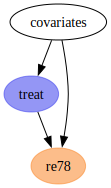

In [3]:
dag = gr.Digraph()

dag.node("treat", color="#2a2eec80", style="filled")
dag.node("re78", color="#fa7c1780", style="filled")
dag.node("covariates")

dag.edge("treat", "re78")
dag.edge("covariates", "treat")
dag.edge("covariates", "re78")

dag

Here's the concrete structure with all covariates shown:

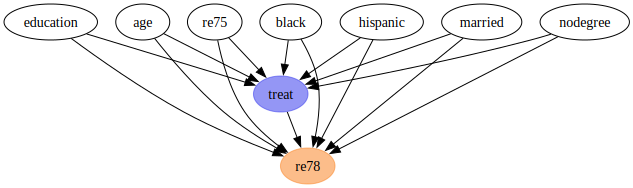

In [4]:
dag = gr.Digraph()

dag.node("treat", color="#2a2eec80", style="filled")
dag.node("re78", color="#fa7c1780", style="filled")

dag.edge("treat", "re78")

for covariate in covariates_names:
    dag.edge(covariate, "treat")
    dag.edge(covariate, "re78")

dag

## Exploratory Data Analysis

/Users/juan.orduz/.local/share/mamba/envs/causal-inference-club-env/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


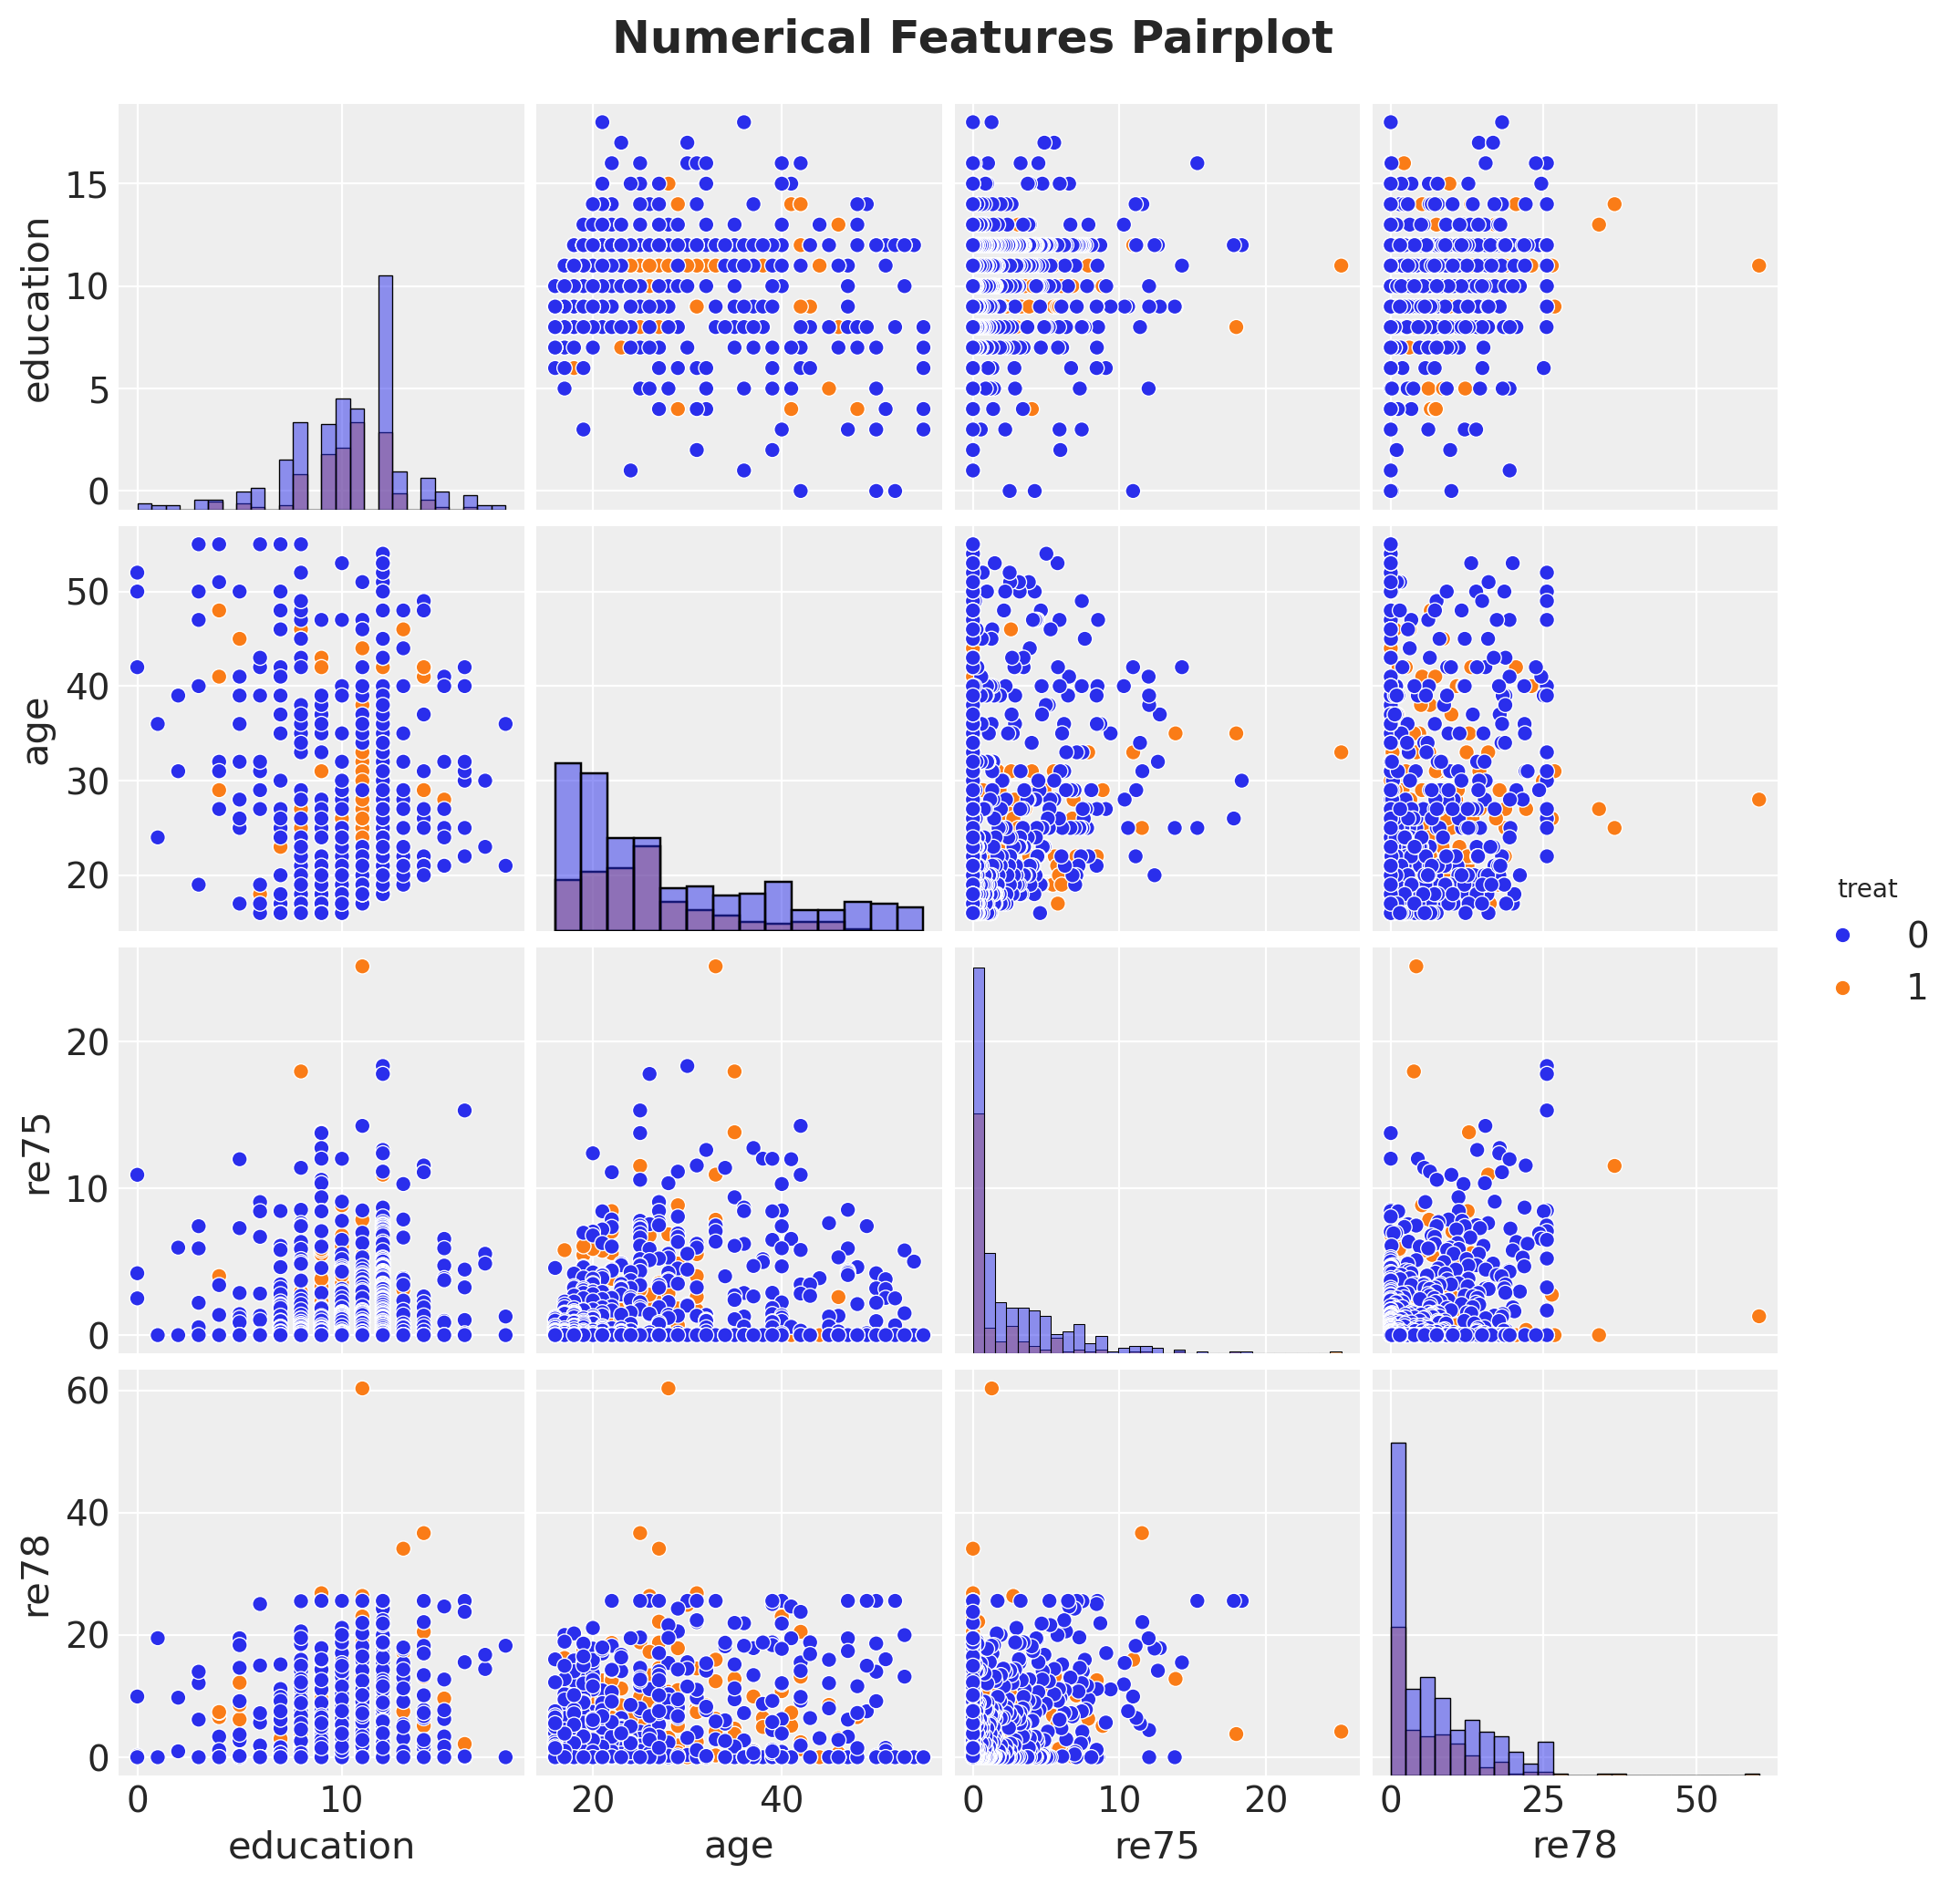

In [5]:
g = sns.pairplot(
    df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist"
)
g.figure.suptitle(
    "Numerical Features Pairplot", fontsize=18, fontweight="bold", y=1.03
);

In [ ]:
# Evaluate what our answer would be if we just naively predicted the average earnings
# of treated and untreated individuals, without accounting for the
# potential confounders.
treated_individuals = df[df["treat"] == 1]
untreated_individuals = df[df["treat"] == 0]

naive_prediction = (
    treated_individuals["re78"].mean() - untreated_individuals["re78"].mean()
)
naive_prediction

np.float64(-0.6350262120374222)

### The Confounding Problem

The naive estimate simply compares average earnings between treated and untreated groups.
However, if these groups differ systematically in pre-treatment characteristics (confounders),
the naive estimate will be biased. For example, if the training program targeted individuals
with lower prior earnings, we'd expect them to have lower earnings regardless of treatment.

This is why we need to adjust for confounders—variables that affect both treatment assignment
and the outcome. Our model will account for these by conditioning on covariates.

In [7]:
df_agg = df.groupby("treat").agg(
    count_education=("education", "count"),
    count_age=("age", "count"),
    count_black=("black", "count"),
    count_hispanic=("hispanic", "count"),
    count_married=("married", "count"),
    count_nodegree=("nodegree", "count"),
    mean_age=("age", "mean"),
    mean_re75=("re75", "mean"),
)

df_agg.style.background_gradient(cmap="viridis", axis=0)

## Scale Numerical Features

In general, it is recommended to scale numerical features to help MCMC sampling converge faster and to think about priors in terms of standard deviations. See [Statistical Rethinking](https://xcelab.net/rm/) by Richard McElreath for more details.

In [8]:
num_features = ["education", "age", "re75"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(with_mean=False), num_features),
    ],
    remainder="passthrough",
).set_output(transform="pandas")


df_transformed = preprocessor.fit_transform(df)
df_transformed.columns = [col.split("__")[-1] for col in df_transformed.columns]

In [9]:
# Convert to arrays
covariates_obs = df_transformed[covariates_names]
training_obs = df_transformed["treat"]
earnings_obs = df_transformed["re78"]

## Specify Model

Now we proceed to specify the model in PyMC.


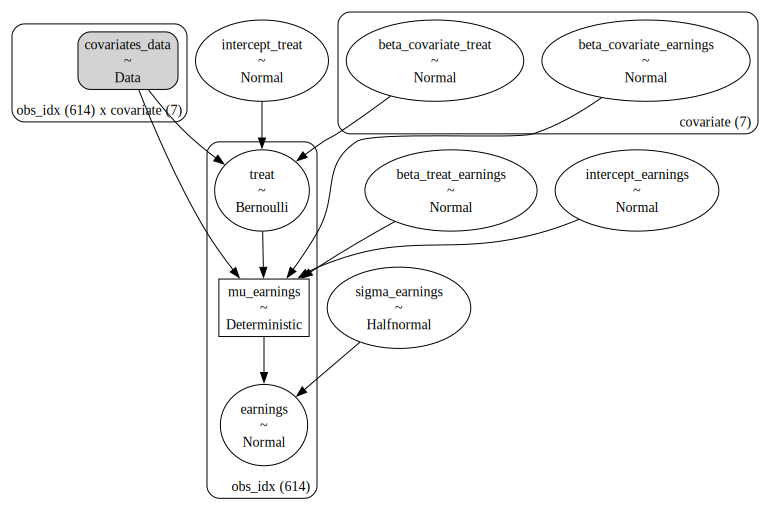

In [10]:
coords = {
    "covariate": covariates_names,
    "obs_idx": df.index,
}

with pm.Model(coords=coords) as earnings_model:
    # TREATMENT MODEL
    # --- Data Containers ---
    covariates_data = pm.Data(
        "covariates_data", covariates_obs, dims=("obs_idx", "covariate")
    )
    # --- Priors ---
    intercept_treat = pm.Normal("intercept_treat", mu=0, sigma=10)
    beta_covariate_treat = pm.Normal(
        "beta_covariate_treat", mu=0, sigma=1, dims=("covariate",)
    )
    # --- Parametrization ---
    logit_p_treat = intercept_treat + pm.math.dot(covariates_data, beta_covariate_treat)
    p_treat = pm.math.sigmoid(logit_p_treat)
    # --- Likelihood ---
    treat = pm.Bernoulli("treat", p=p_treat, dims=("obs_idx",))

    # EARNINGS MODEL
    # --- Priors ---
    intercept_earnings = pm.Normal("intercept_earnings", mu=0, sigma=10)
    beta_treat_earnings = pm.Normal("beta_treat_earnings", mu=0, sigma=1)
    beta_covariate_earnings = pm.Normal(
        "beta_covariate_earnings", mu=0, sigma=1, dims=("covariate",)
    )
    sigma_earnings = pm.HalfNormal("sigma_earnings", sigma=10.0)

    mu_earnings = pm.Deterministic(
        "mu_earnings",
        intercept_earnings
        + beta_treat_earnings * treat
        + pm.math.dot(covariates_data, beta_covariate_earnings),
        dims=("obs_idx",),
    )
    # --- Likelihood ---
    pm.Normal(
        "earnings",
        mu=mu_earnings,
        sigma=sigma_earnings,
        dims=("obs_idx",),
    )

pm.model_to_graphviz(earnings_model)

## Prior Predictive Checks

Before we fit the model, we can check samples from the prior distribution and compare them with the observed data.

In [11]:
with earnings_model:
    idata = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

Sampling: [beta_covariate_earnings, beta_covariate_treat, beta_treat_earnings, earnings, intercept_earnings, intercept_treat, sigma_earnings, treat]


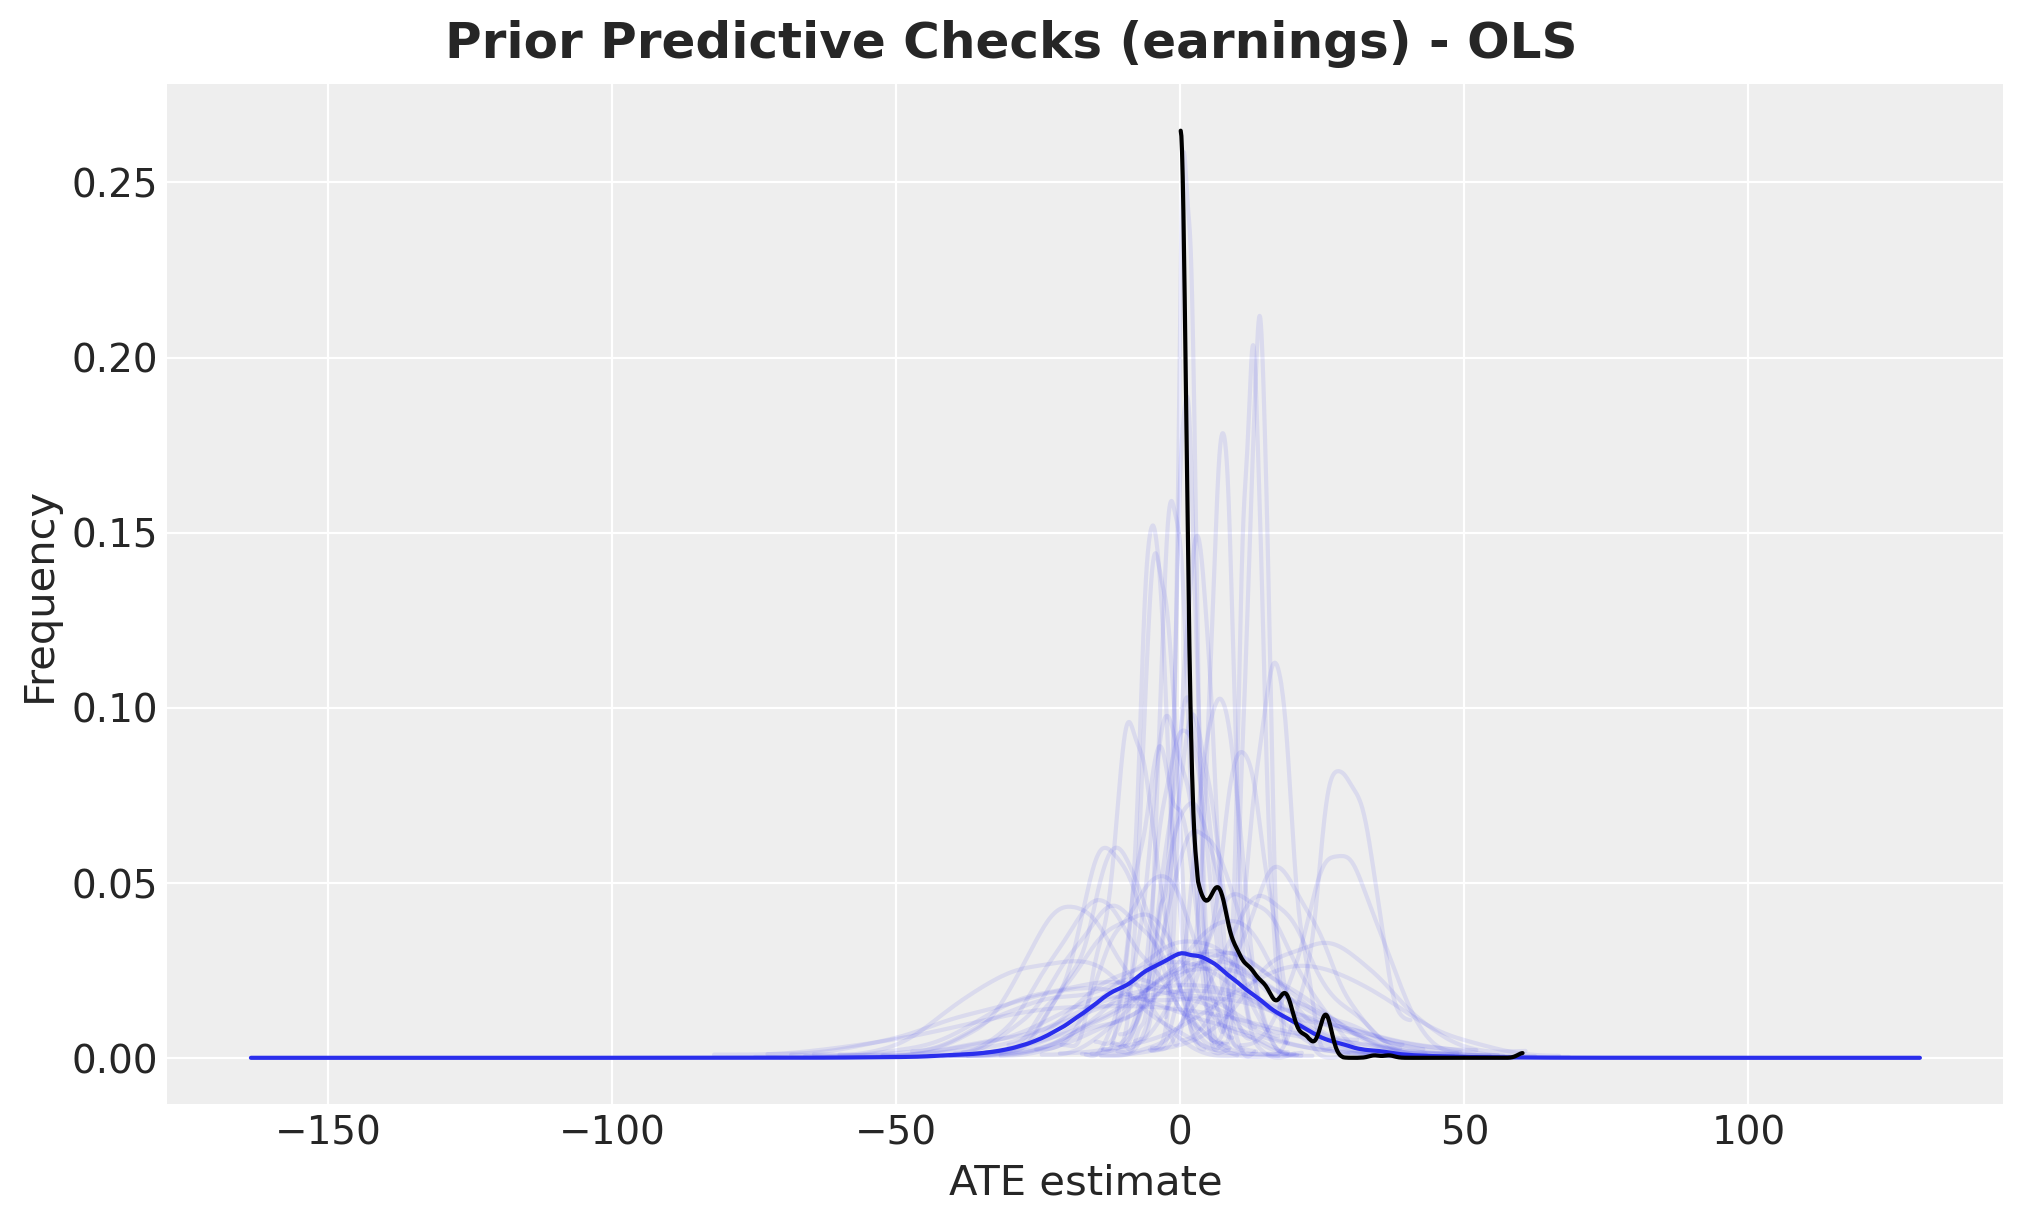

In [12]:
fig, ax = plt.subplots()
az.plot_dist(idata["prior"]["earnings"].to_numpy().flatten(), color="C0", ax=ax)

for i in range(50):
    az.plot_dist(
        idata["prior"]["earnings"].sel(draw=i, chain=0),
        color="C0",
        plot_kwargs={"alpha": 0.1},
        ax=ax,
    )

az.plot_dist(earnings_obs, color="black", ax=ax)
ax.set(xlabel="ATE estimate", ylabel="Frequency")
fig.suptitle(
    "Prior Predictive Checks (earnings) - OLS", fontsize=18, fontweight="bold"
);

Overall, the prior predictive distribution looks reasonable. However, we notice that this simple
linear model allows negative earnings, which is unrealistic. We'll address this limitation later
when we introduce a generalized linear model.

Next, let's examine the prior predictive distribution of the `beta_treat_earnings` coefficient,
which represents the average treatment effect (ATE).

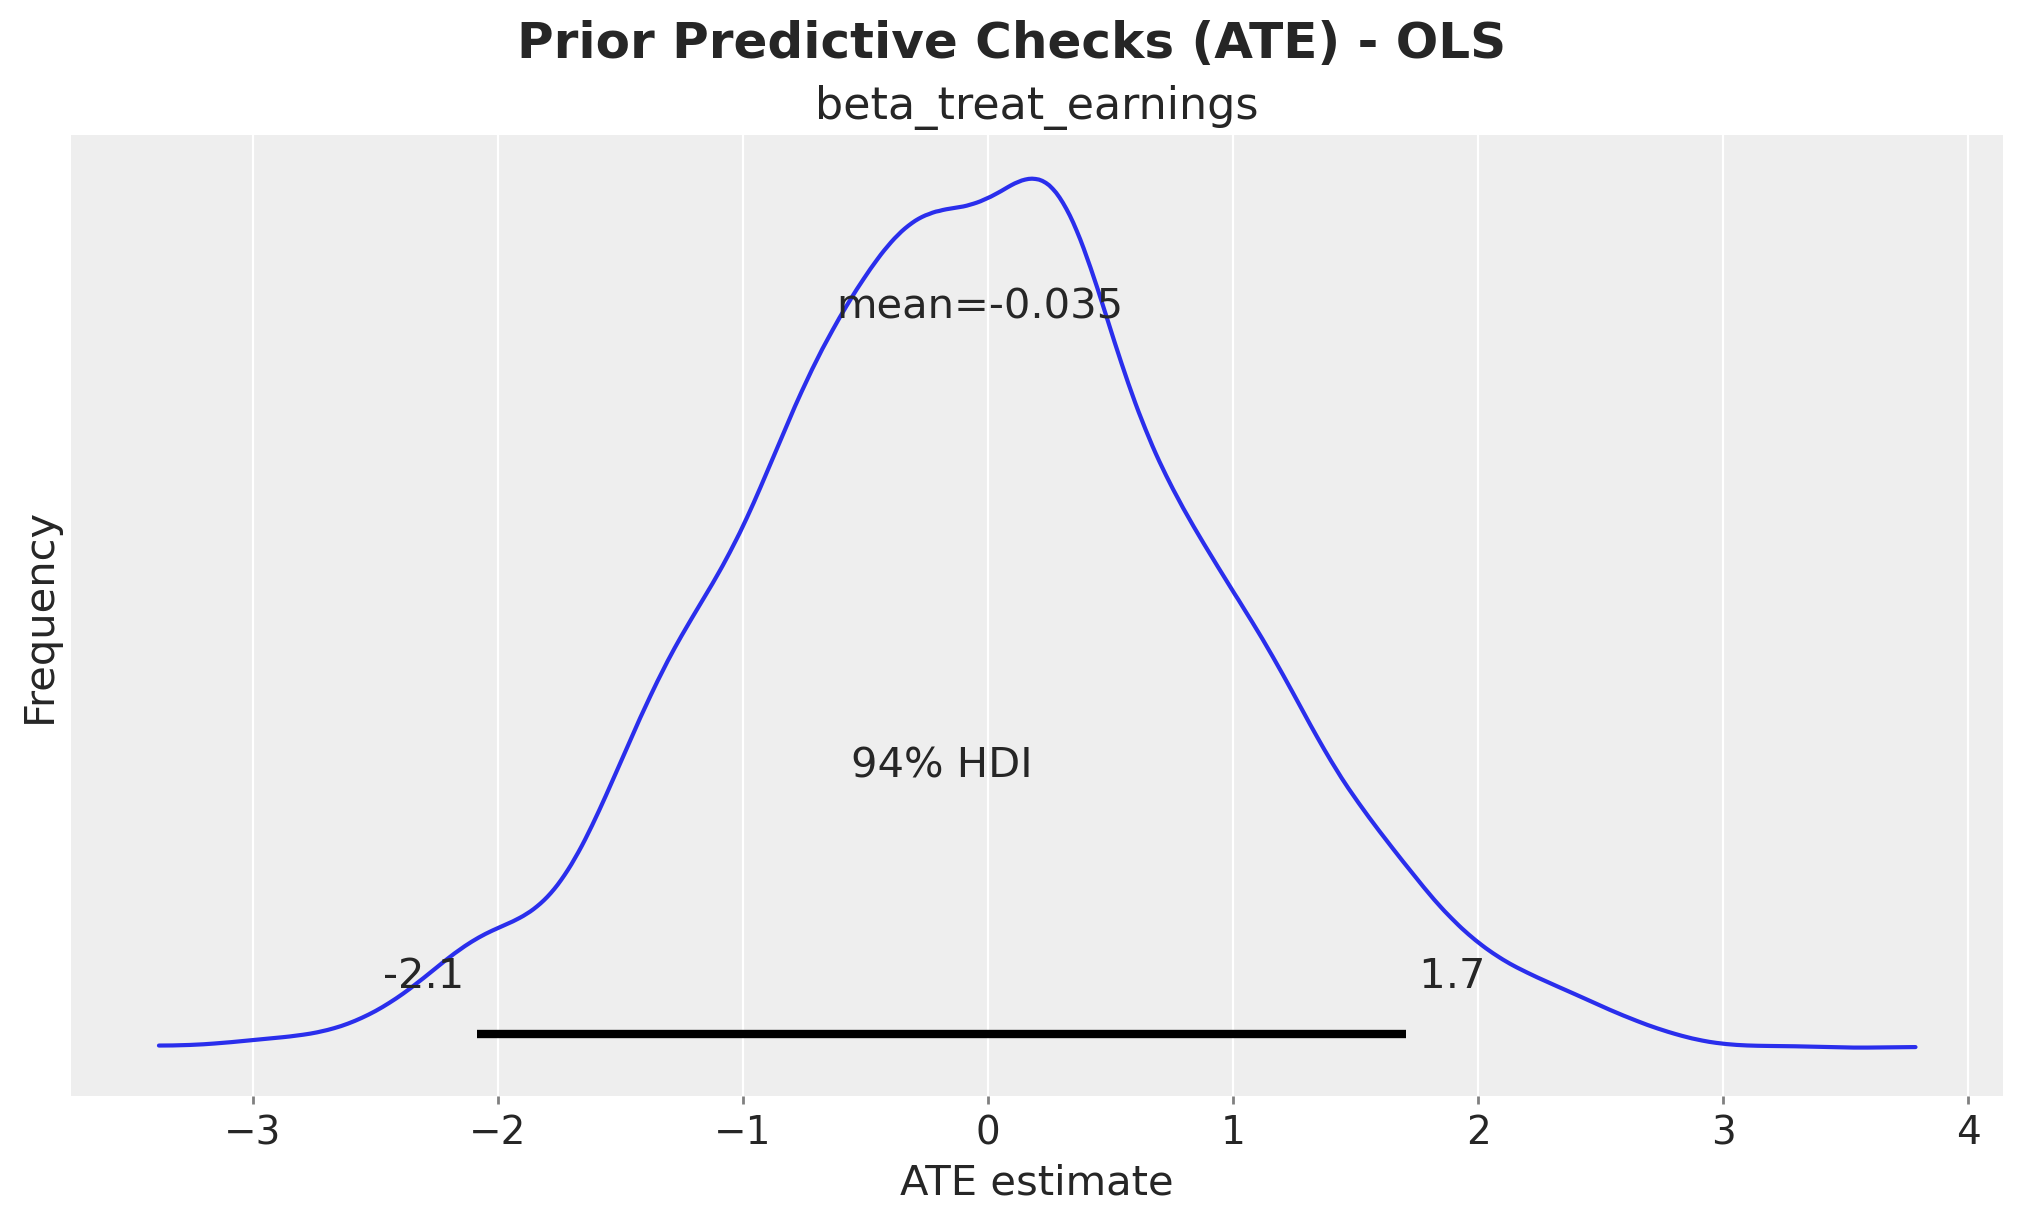

In [13]:
fig, ax = plt.subplots()
az.plot_posterior(idata["prior"], var_names=["beta_treat_earnings"], ax=ax)
ax.set(xlabel="ATE estimate", ylabel="Frequency")
fig.suptitle("Prior Predictive Checks (ATE) - OLS", fontsize=18, fontweight="bold");

The prior distribution of `beta_treat_earnings` is centered around $0$, which is expected since
we haven't conditioned the model on the data yet. The $94\%$ high density interval (HDI) spans
approximately $-2$ to $2$, which is not very informative but provides reasonable regularization.

## Model Fit

Now we condition the model on the observed data and sample from the posterior distribution using
MCMC (we could also use stochastic variational inference or other methods to scale up).

Let's take a look at the conditioned model:

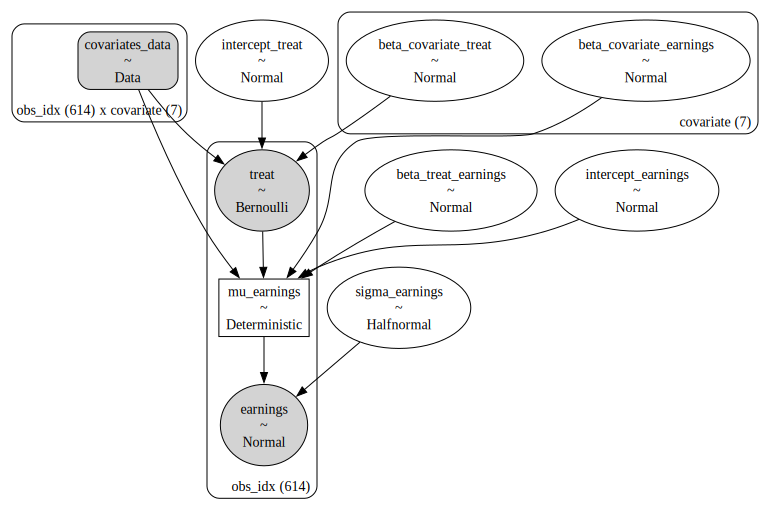

In [14]:
conditioned_earnings_model = observe(
    earnings_model, {"treat": training_obs, "earnings": earnings_obs}
)

pm.model_to_graphviz(conditioned_earnings_model)

We run NUTS to sample from the posterior distribution.

In [15]:
sample_kwargs = {
    "draws": 2_000,
    "tune": 1_000,
    "chains": 4,
    "cores": 4,
    "idata_kwargs": {"log_likelihood": True},
    "random_seed": rng,
}

with conditioned_earnings_model:
    idata.extend(pm.sample(**sample_kwargs))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_covariate_earnings, beta_covariate_treat, intercept_treat, beta_treat_earnings, intercept_earnings, sigma_earnings]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


## Diagnostics

We need to assess the quality of our posterior samples. First, let's examine the trace plots
to verify that the chains are mixing well.

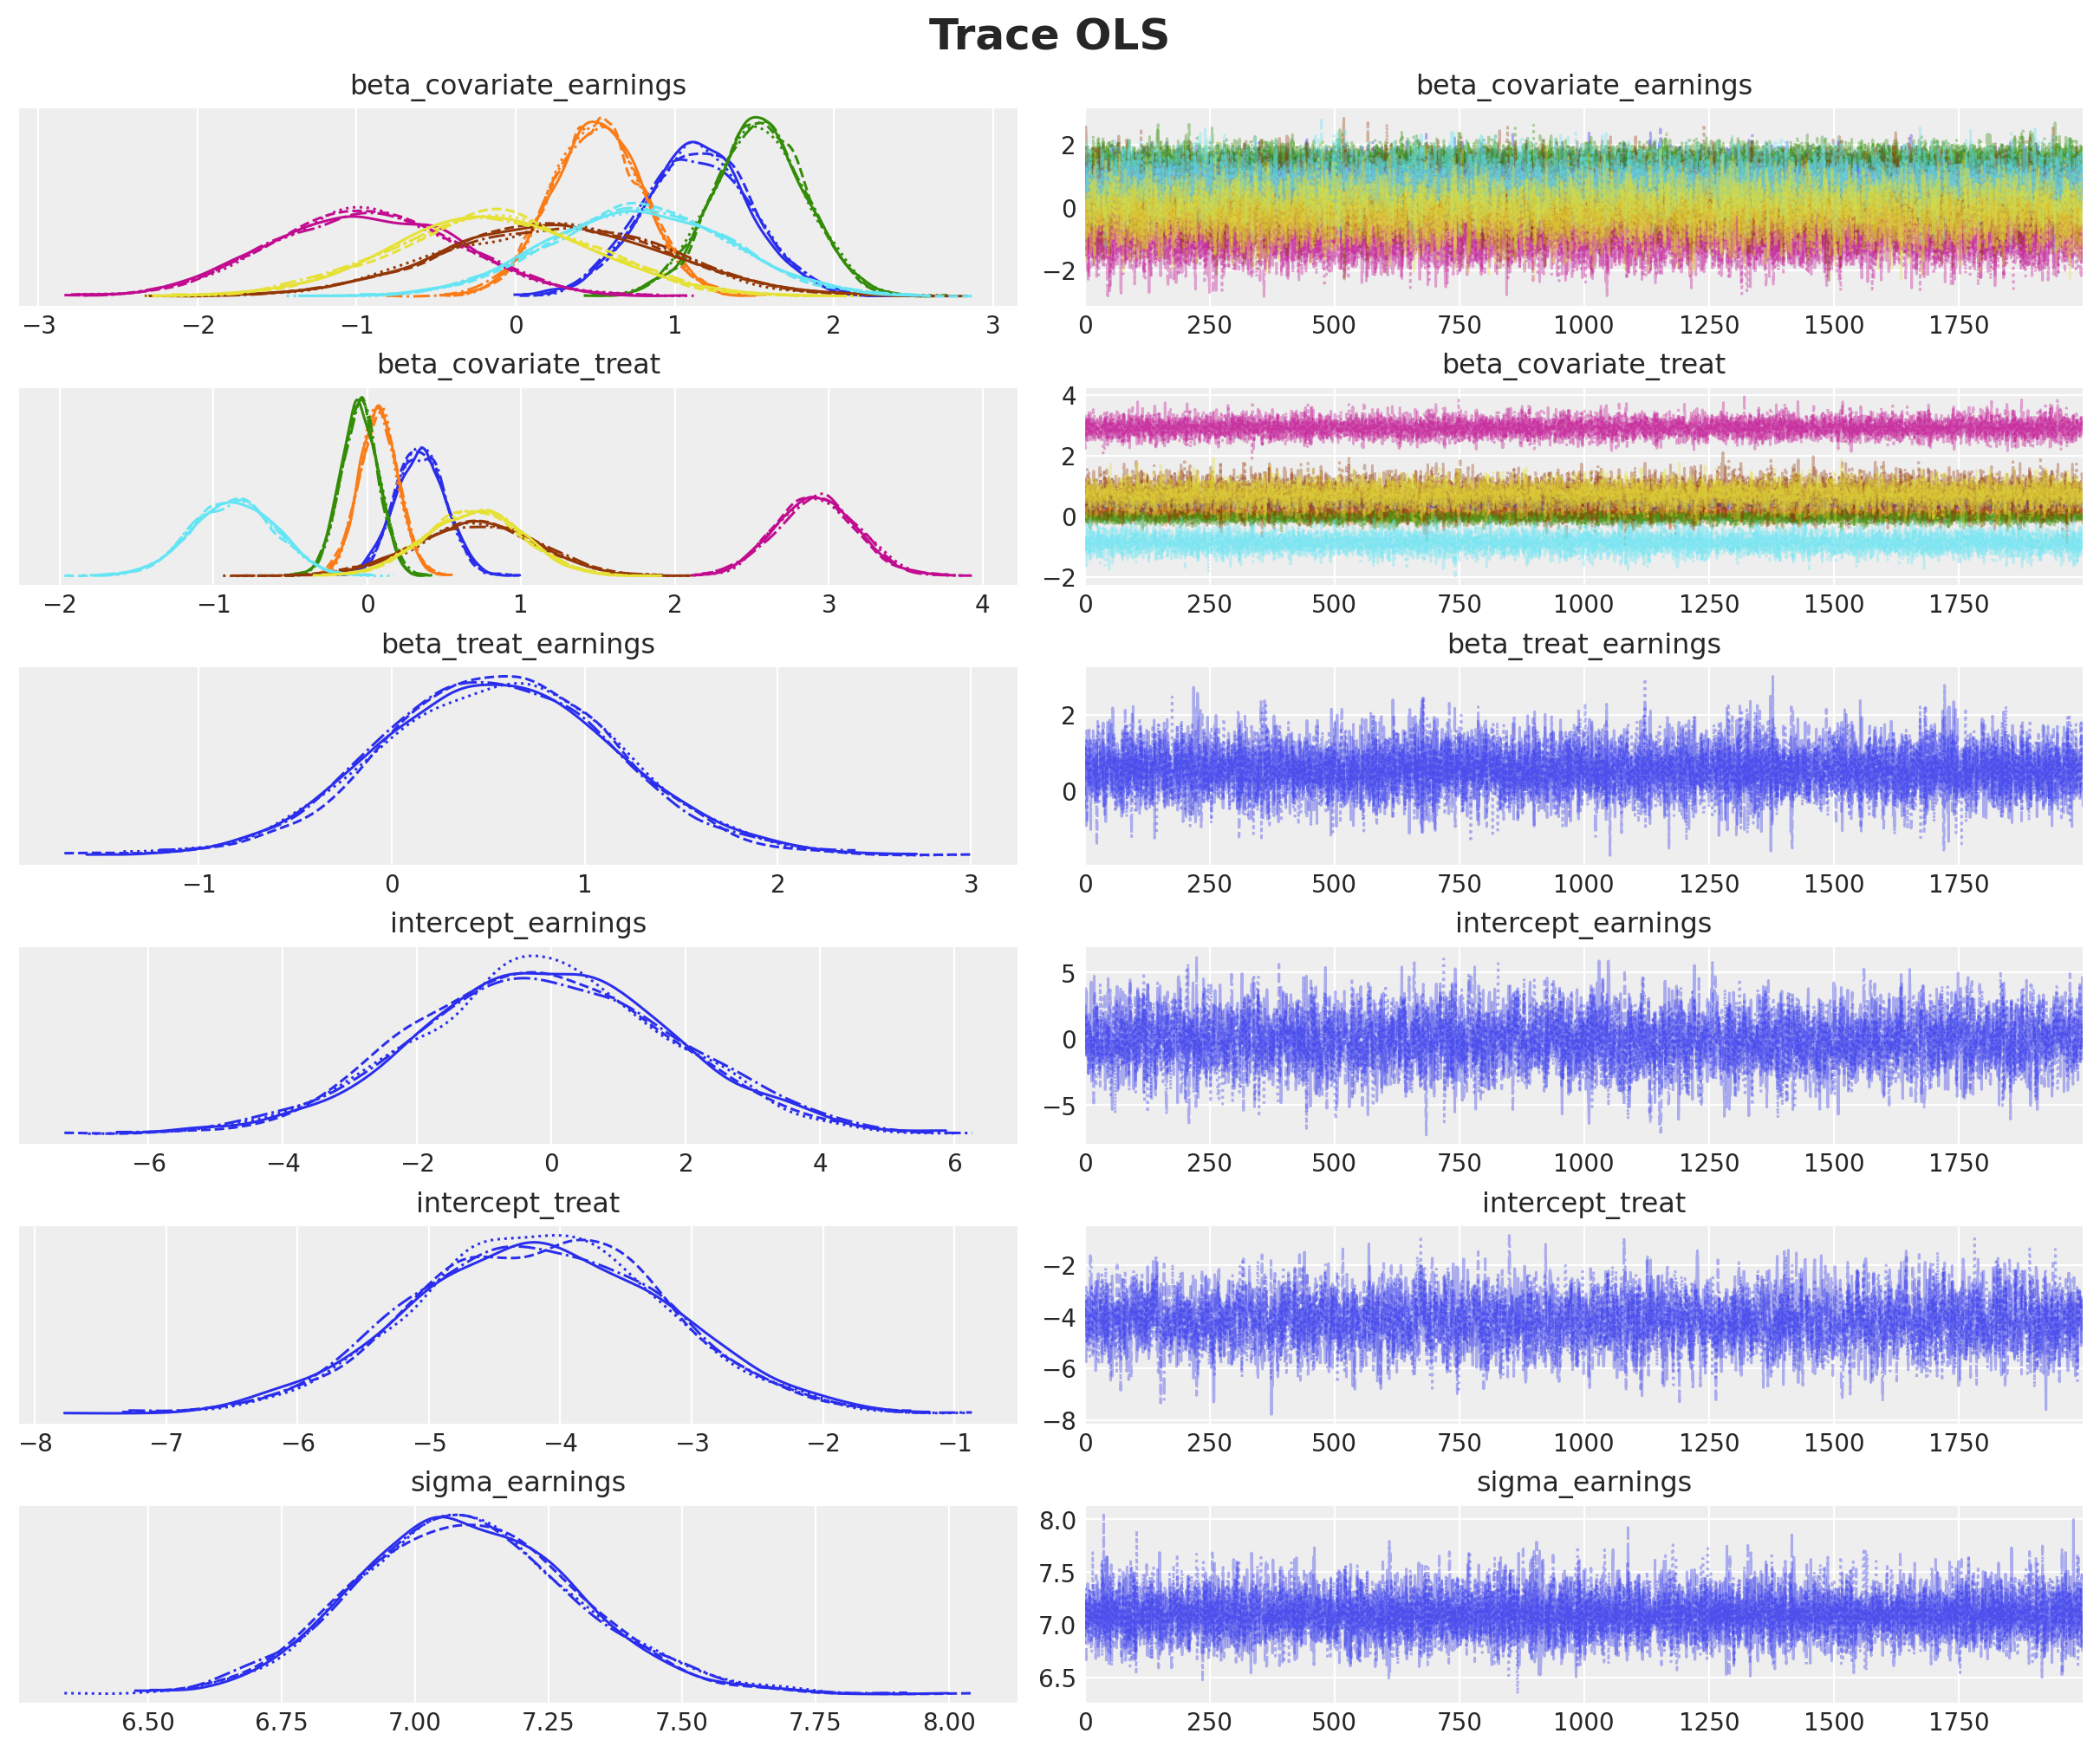

In [16]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu_earnings"],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace OLS", fontsize=18, fontweight="bold");

In [17]:
az.summary(idata, var_names=["~mu_earnings"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
beta_covariate_earnings[education]  1.138  0.338   0.509    1.779      0.005   
beta_covariate_earnings[age]        0.511  0.291  -0.028    1.062      0.003   
beta_covariate_earnings[re75]       1.530  0.292   0.977    2.082      0.003   
beta_covariate_earnings[black]     -0.950  0.585  -2.020    0.157      0.006   
beta_covariate_earnings[hispanic]   0.241  0.705  -1.051    1.573      0.007   
beta_covariate_earnings[married]    0.771  0.568  -0.274    1.851      0.006   
beta_covariate_earnings[nodegree]  -0.149  0.631  -1.346    1.010      0.008   
beta_covariate_treat[education]     0.345  0.162   0.036    0.637      0.002   
beta_covariate_treat[age]           0.074  0.127  -0.157    0.319      0.001   
beta_covariate_treat[re75]         -0.049  0.122  -0.284    0.172      0.001   
beta_covariate_treat[black]         2.919  0.261   2.440    3.411      0.003   
beta_covariate_treat[hispanic]      0.707  0.393  -0.039    1.439      0.004   
beta_covariate_treat[married]      -0.869  0.271  -1.360   -0.352      0.003   
beta_covariate_treat[nodegree]      0.696  0.314   0.124    1.295      0.004   
beta_treat_earnings                 0.552  0.604  -0.547    1.723      0.006   
intercept_earnings                 -0.135  1.927  -3.581    3.682      0.028   
intercept_treat                    -4.166  0.952  -5.932   -2.355      0.015   
sigma_earnings                      7.095  0.205   6.728    7.497      0.002   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
beta_covariate_earnings[education]    0.003    5015.0    6027.0    1.0  
beta_covariate_earnings[age]          0.003    9449.0    6066.0    1.0  
beta_covariate_earnings[re75]         0.004   10929.0    5306.0    1.0  
beta_covariate_earnings[black]        0.006    9958.0    6330.0    1.0  
beta_covariate_earnings[hispanic]     0.008   10817.0    5873.0    1.0  
beta_covariate_earnings[married]      0.007    9867.0    5652.0    1.0  
beta_covariate_earnings[nodegree]     0.006    6092.0    6278.0    1.0  
beta_covariate_treat[education]       0.002    4276.0    5184.0    1.0  
beta_covariate_treat[age]             0.001    7512.0    6169.0    1.0  
beta_covariate_treat[re75]            0.002   10216.0    5178.0    1.0  
beta_covariate_treat[black]           0.003    9331.0    6283.0    1.0  
beta_covariate_treat[hispanic]        0.004    9969.0    6337.0    1.0  
beta_covariate_treat[married]         0.003   10465.0    6317.0    1.0  
beta_covariate_treat[nodegree]        0.003    4986.0    5839.0    1.0  
beta_treat_earnings                   0.007   11845.0    6154.0    1.0  
intercept_earnings                    0.020    4608.0    5419.0    1.0  
intercept_treat                       0.010    3836.0    5116.0    1.0  
sigma_earnings                        0.003   13129.0    5184.0    1.0

**R-hat (Gelman-Rubin statistic)**: Measures agreement between chains. R-hat ≈ 1.0 means
chains have converged to the same distribution. Values > 1.1 suggest the sampler hasn't
converged yet.

**ESS (Effective Sample Size)**: Measures how many independent samples we effectively have.
Low ESS means samples are highly correlated, reducing the information we can extract.
We want ESS > 400 for reliable credible intervals.

## Posterior Predictive Sampling

We now extend the InferenceData object with posterior predictive samples to assess model fit.

In [18]:
with conditioned_earnings_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [earnings, treat]


Output()

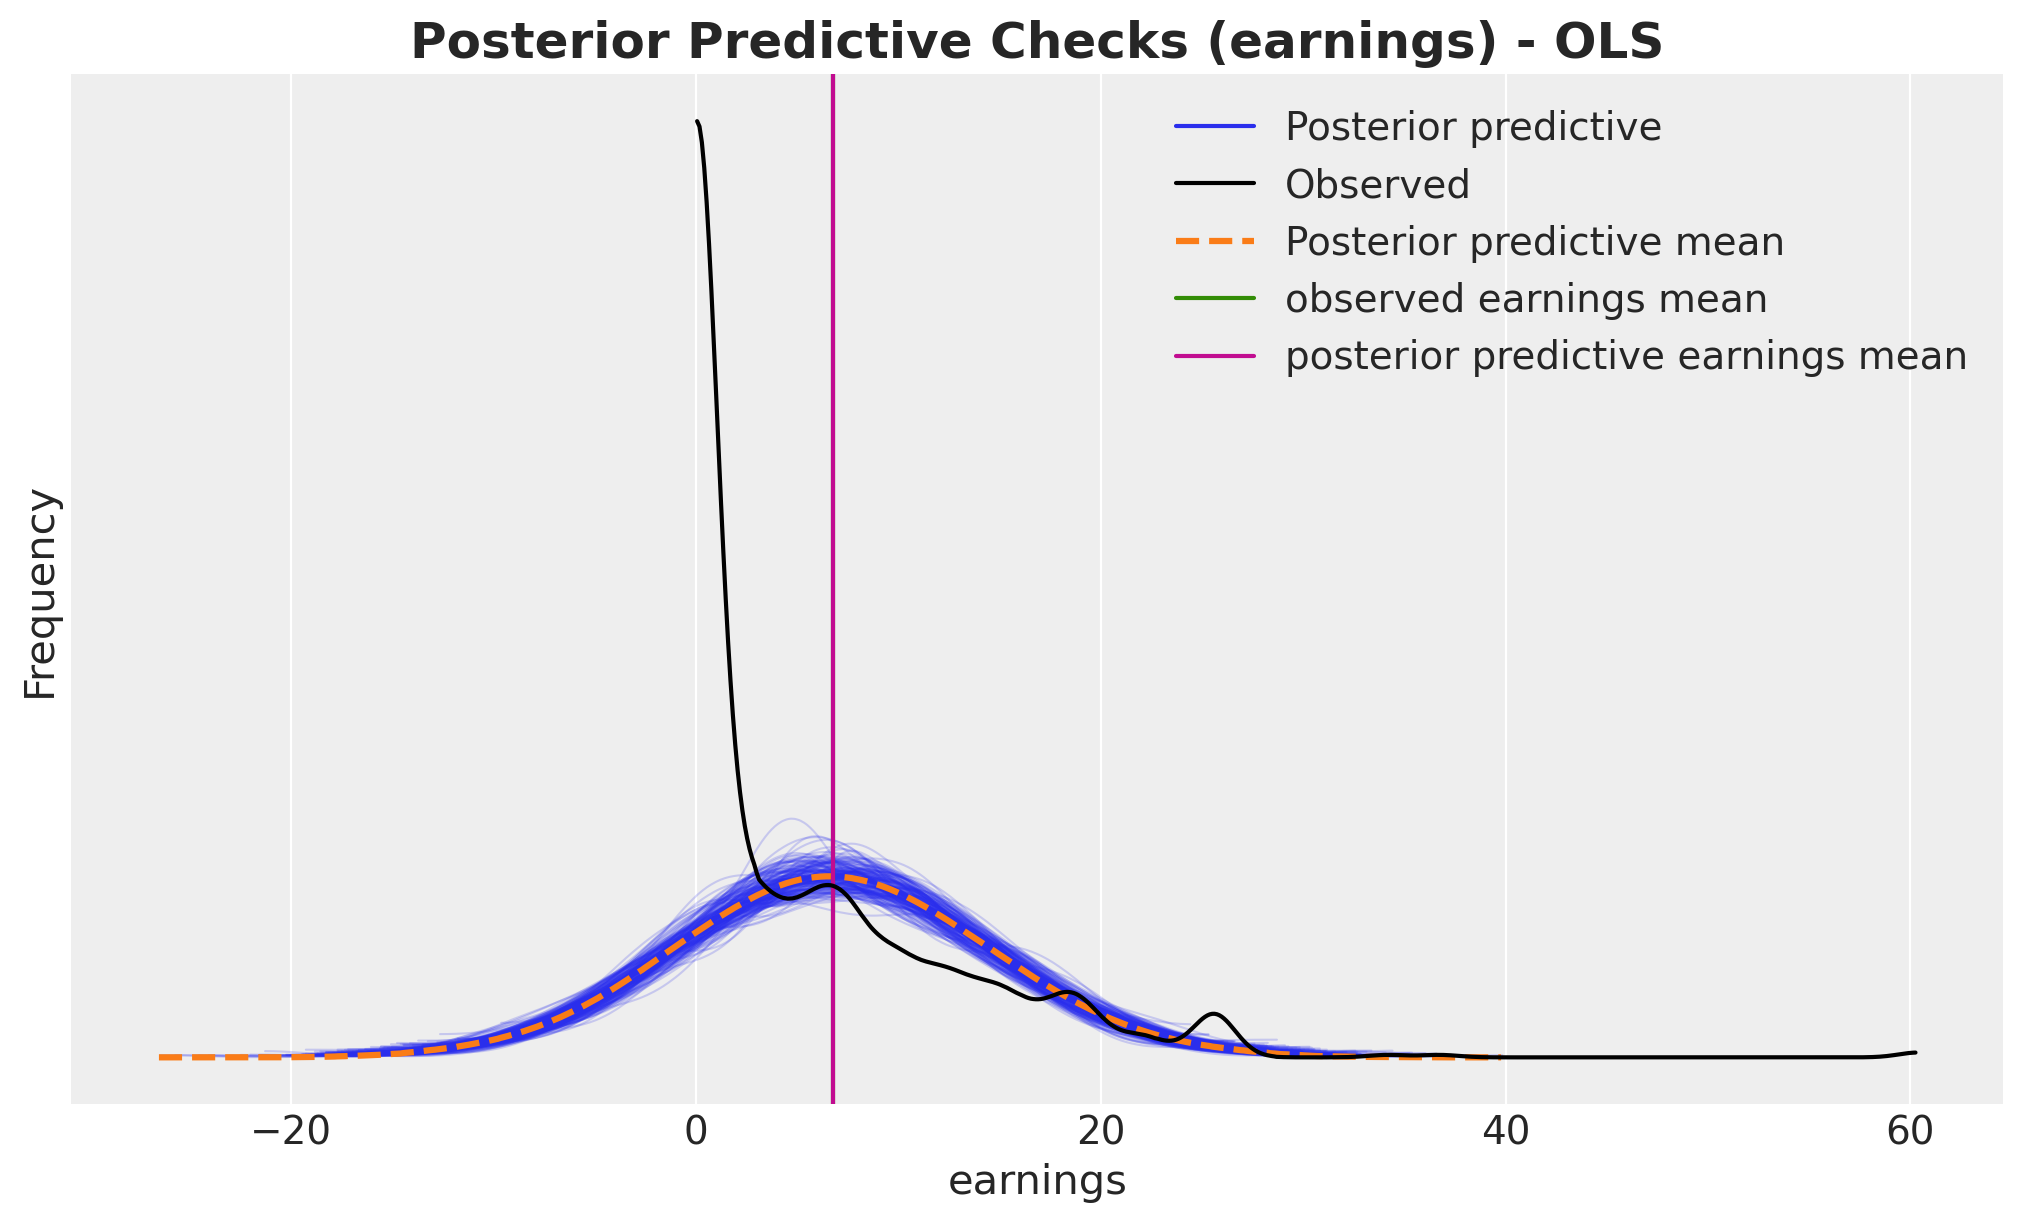

In [19]:
fig, ax = plt.subplots()
az.plot_ppc(idata, var_names=["earnings"], num_pp_samples=200, ax=ax)
ax.axvline(earnings_obs.mean(), color="C2", label="observed earnings mean")
ax.axvline(
    idata["posterior_predictive"]["earnings"].mean().item(),
    color="C3",
    label="posterior predictive earnings mean",
)
ax.legend()
ax.set(xlabel="earnings", ylabel="Frequency")
ax.set_title(
    "Posterior Predictive Checks (earnings) - OLS", fontsize=18, fontweight="bold"
);

## ATE Estimation from Coefficient

In our linear model, `beta_treat_earnings` directly represents the Average Treatment Effect.
Since we've adjusted for confounders, this coefficient tells us the expected change in earnings
from treatment while holding all covariates constant—exactly the causal interpretation we want.

Following the ChiRho tutorial, we compare our ATE estimate with results from other methods.

In [20]:
# https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html
blog_prediction_ols = (
    1_548.24 / 1_000
)  # Scaled by 1000 to be consistent with data preprocessing above.
blog_prediction_matching = 1_027.087 / 1_000
blog_prediction_matching_ci95 = [-705.131 / 1_000, 2_759.305 / 1_000]

Let's visualize the ATE estimates:

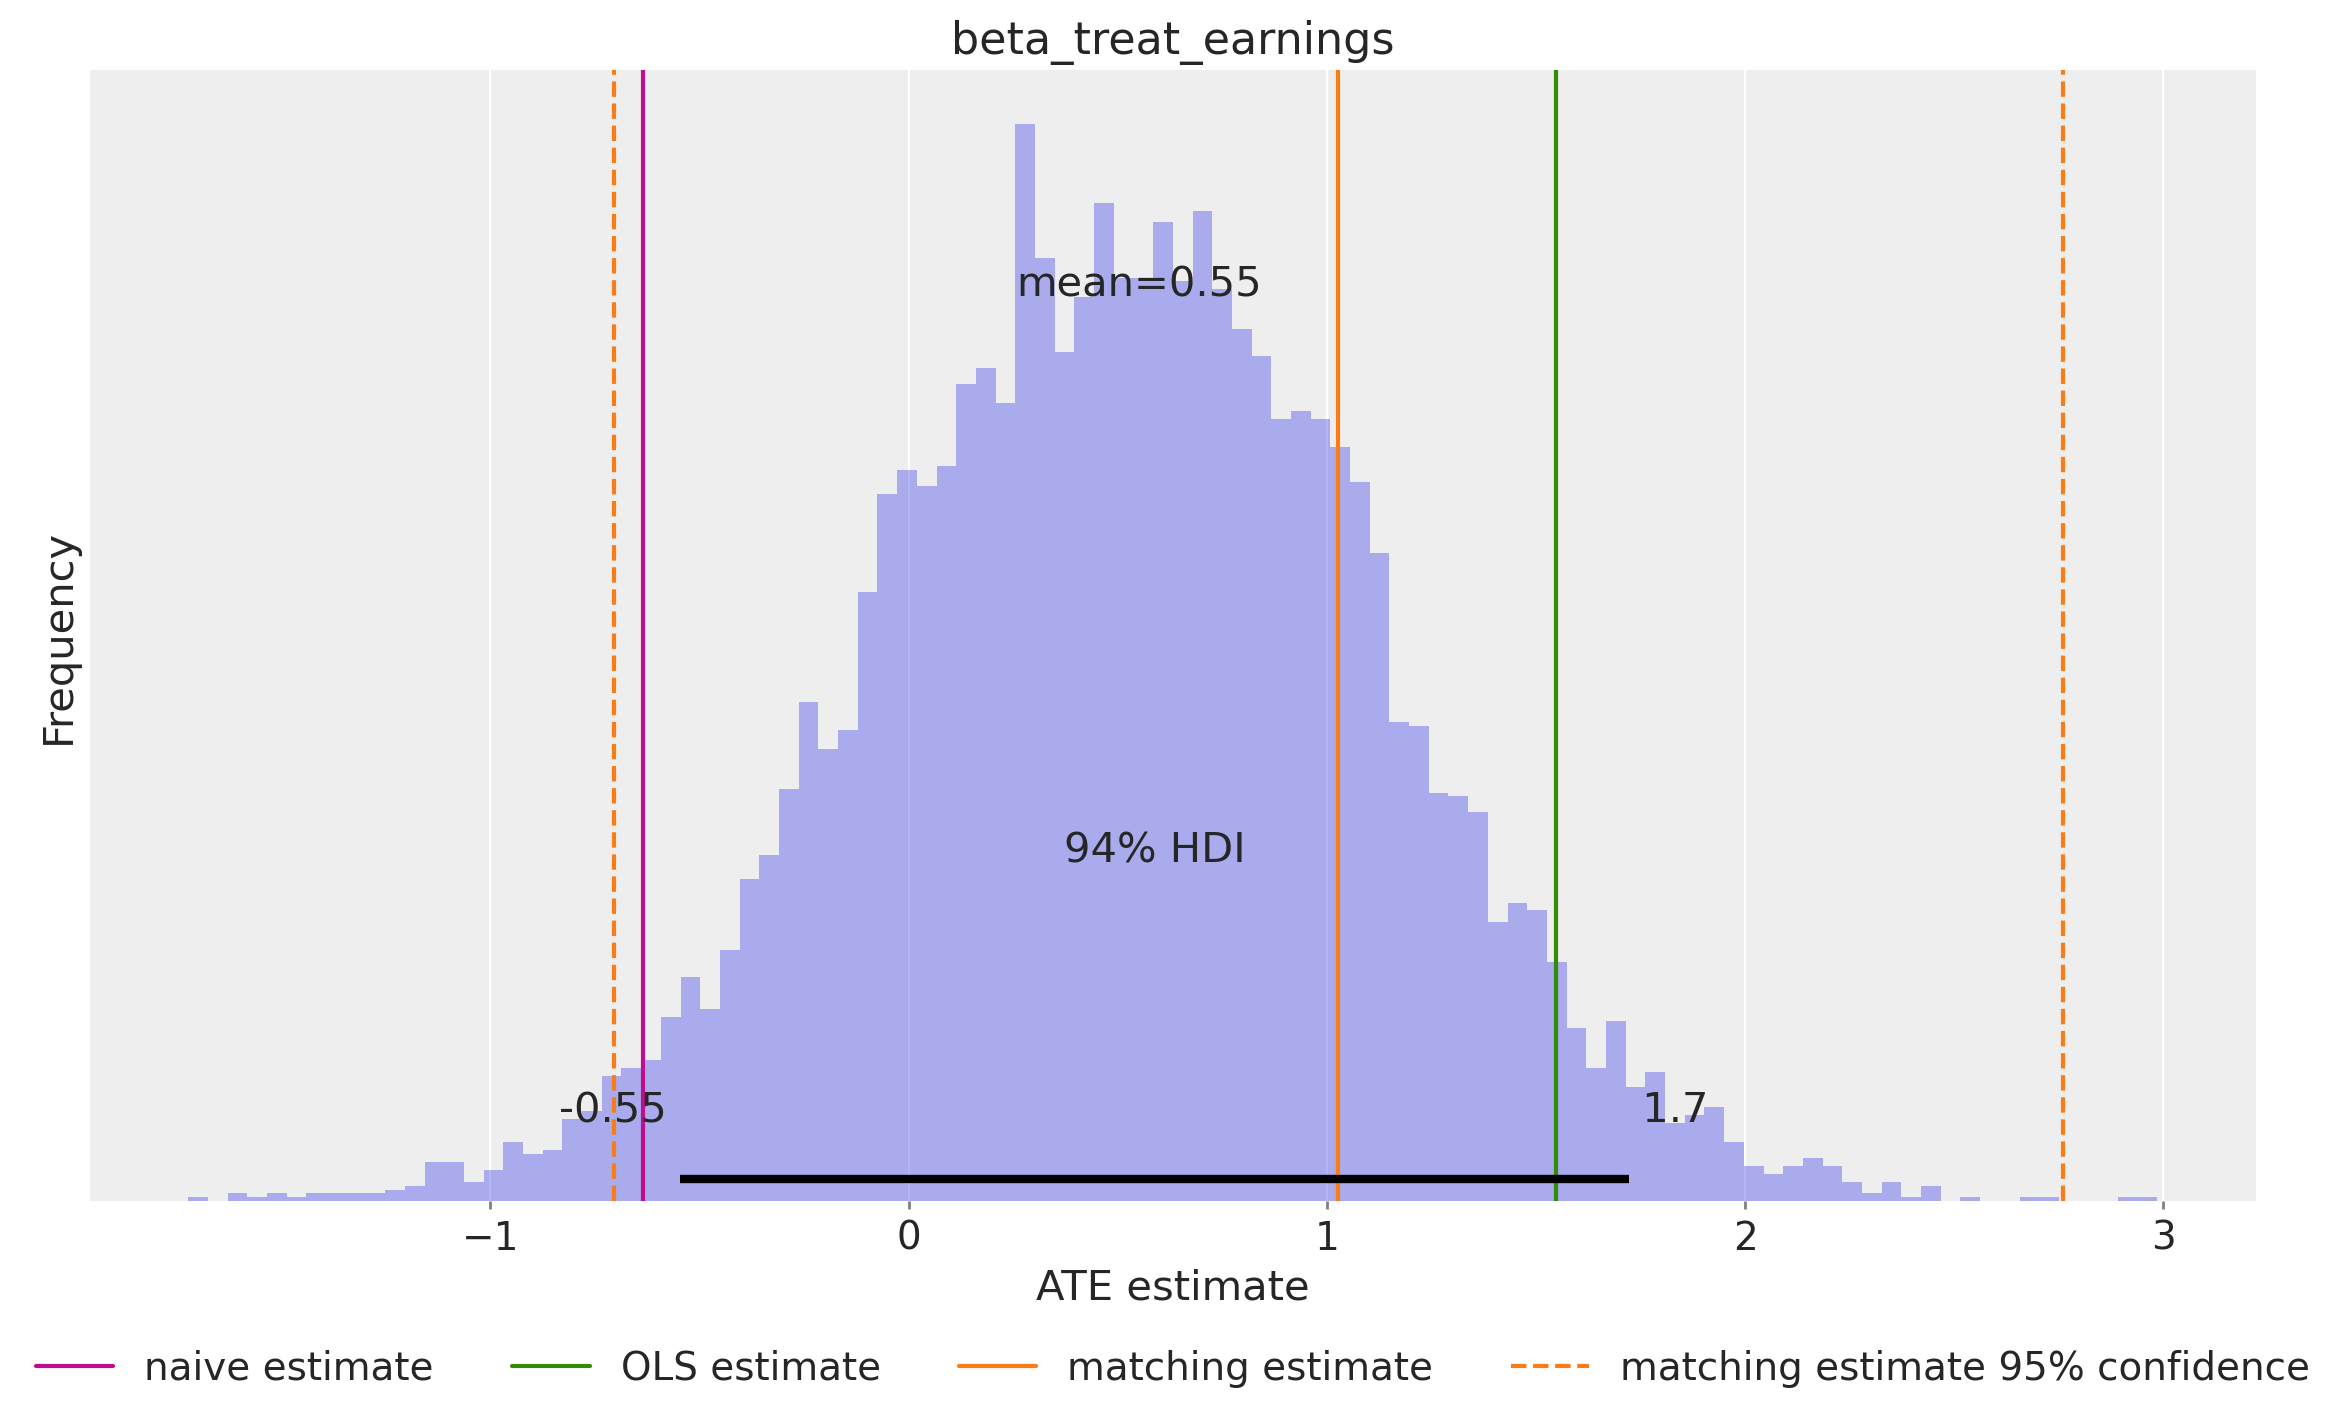

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(naive_prediction, color="C3", label="naive estimate")
ax.axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax.axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax.axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax.axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(
    idata["posterior"], var_names=["beta_treat_earnings"], kind="hist", bins=100, ax=ax
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="ATE estimate", ylabel="Frequency");

## ATE Estimation using the `do` Operator

The `do` operator represents an intervention: we force treatment to a specific value,
breaking any dependence on confounders. This is the mathematical representation of
"what if everyone received treatment?" vs "what if no one received treatment?"

The difference between these counterfactual outcomes is the ATE. This approach is more
general than coefficient interpretation—it works even with non-linear models. In our
linear case, it should match the coefficient-based estimate.

Let's apply the `do` operator to our model.

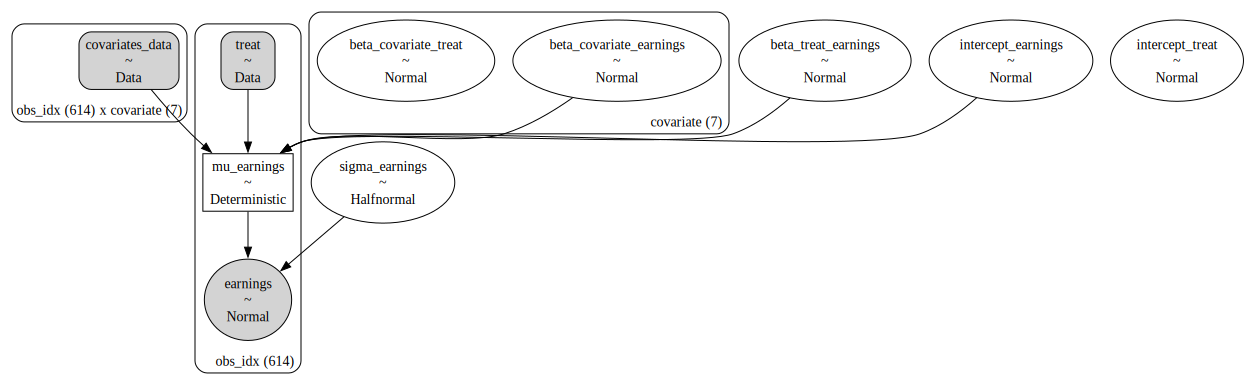

In [22]:
do_0_earnings_model = do(
    conditioned_earnings_model, {"treat": np.zeros(shape=(n_obs,), dtype=np.int32)}
)

do_1_earnings_model = do(
    conditioned_earnings_model, {"treat": np.ones(shape=(n_obs,), dtype=np.int32)}
)

pm.model_to_graphviz(do_0_earnings_model)

We now generate posterior predictive samples for both counterfactual scenarios (do(treat = 0)
and do(treat = 1)) using the posterior samples from our MCMC fit. These represent the inferred
counterfactual outcomes.

In [23]:
with do_0_earnings_model:
    do_0_idata = pm.sample_posterior_predictive(
        idata, random_seed=rng, var_names=["mu_earnings"]
    )

with do_1_earnings_model:
    do_1_idata = pm.sample_posterior_predictive(
        idata, random_seed=rng, var_names=["mu_earnings"]
    )

Sampling: []


Output()

Sampling: []


Output()

Let's extract the posterior predictions and visualize the individual posterior predictive distributions.

In [24]:
expected_do_1 = do_1_idata["posterior_predictive"]["mu_earnings"]
expected_do_0 = do_0_idata["posterior_predictive"]["mu_earnings"]
# Compute the HDIs
do_0_hdi = az.hdi(expected_do_0)["mu_earnings"]
do_1_hdi = az.hdi(expected_do_1)["mu_earnings"]

We can now visualize and compare the two posterior predictive distributions for each individual
in the dataset.

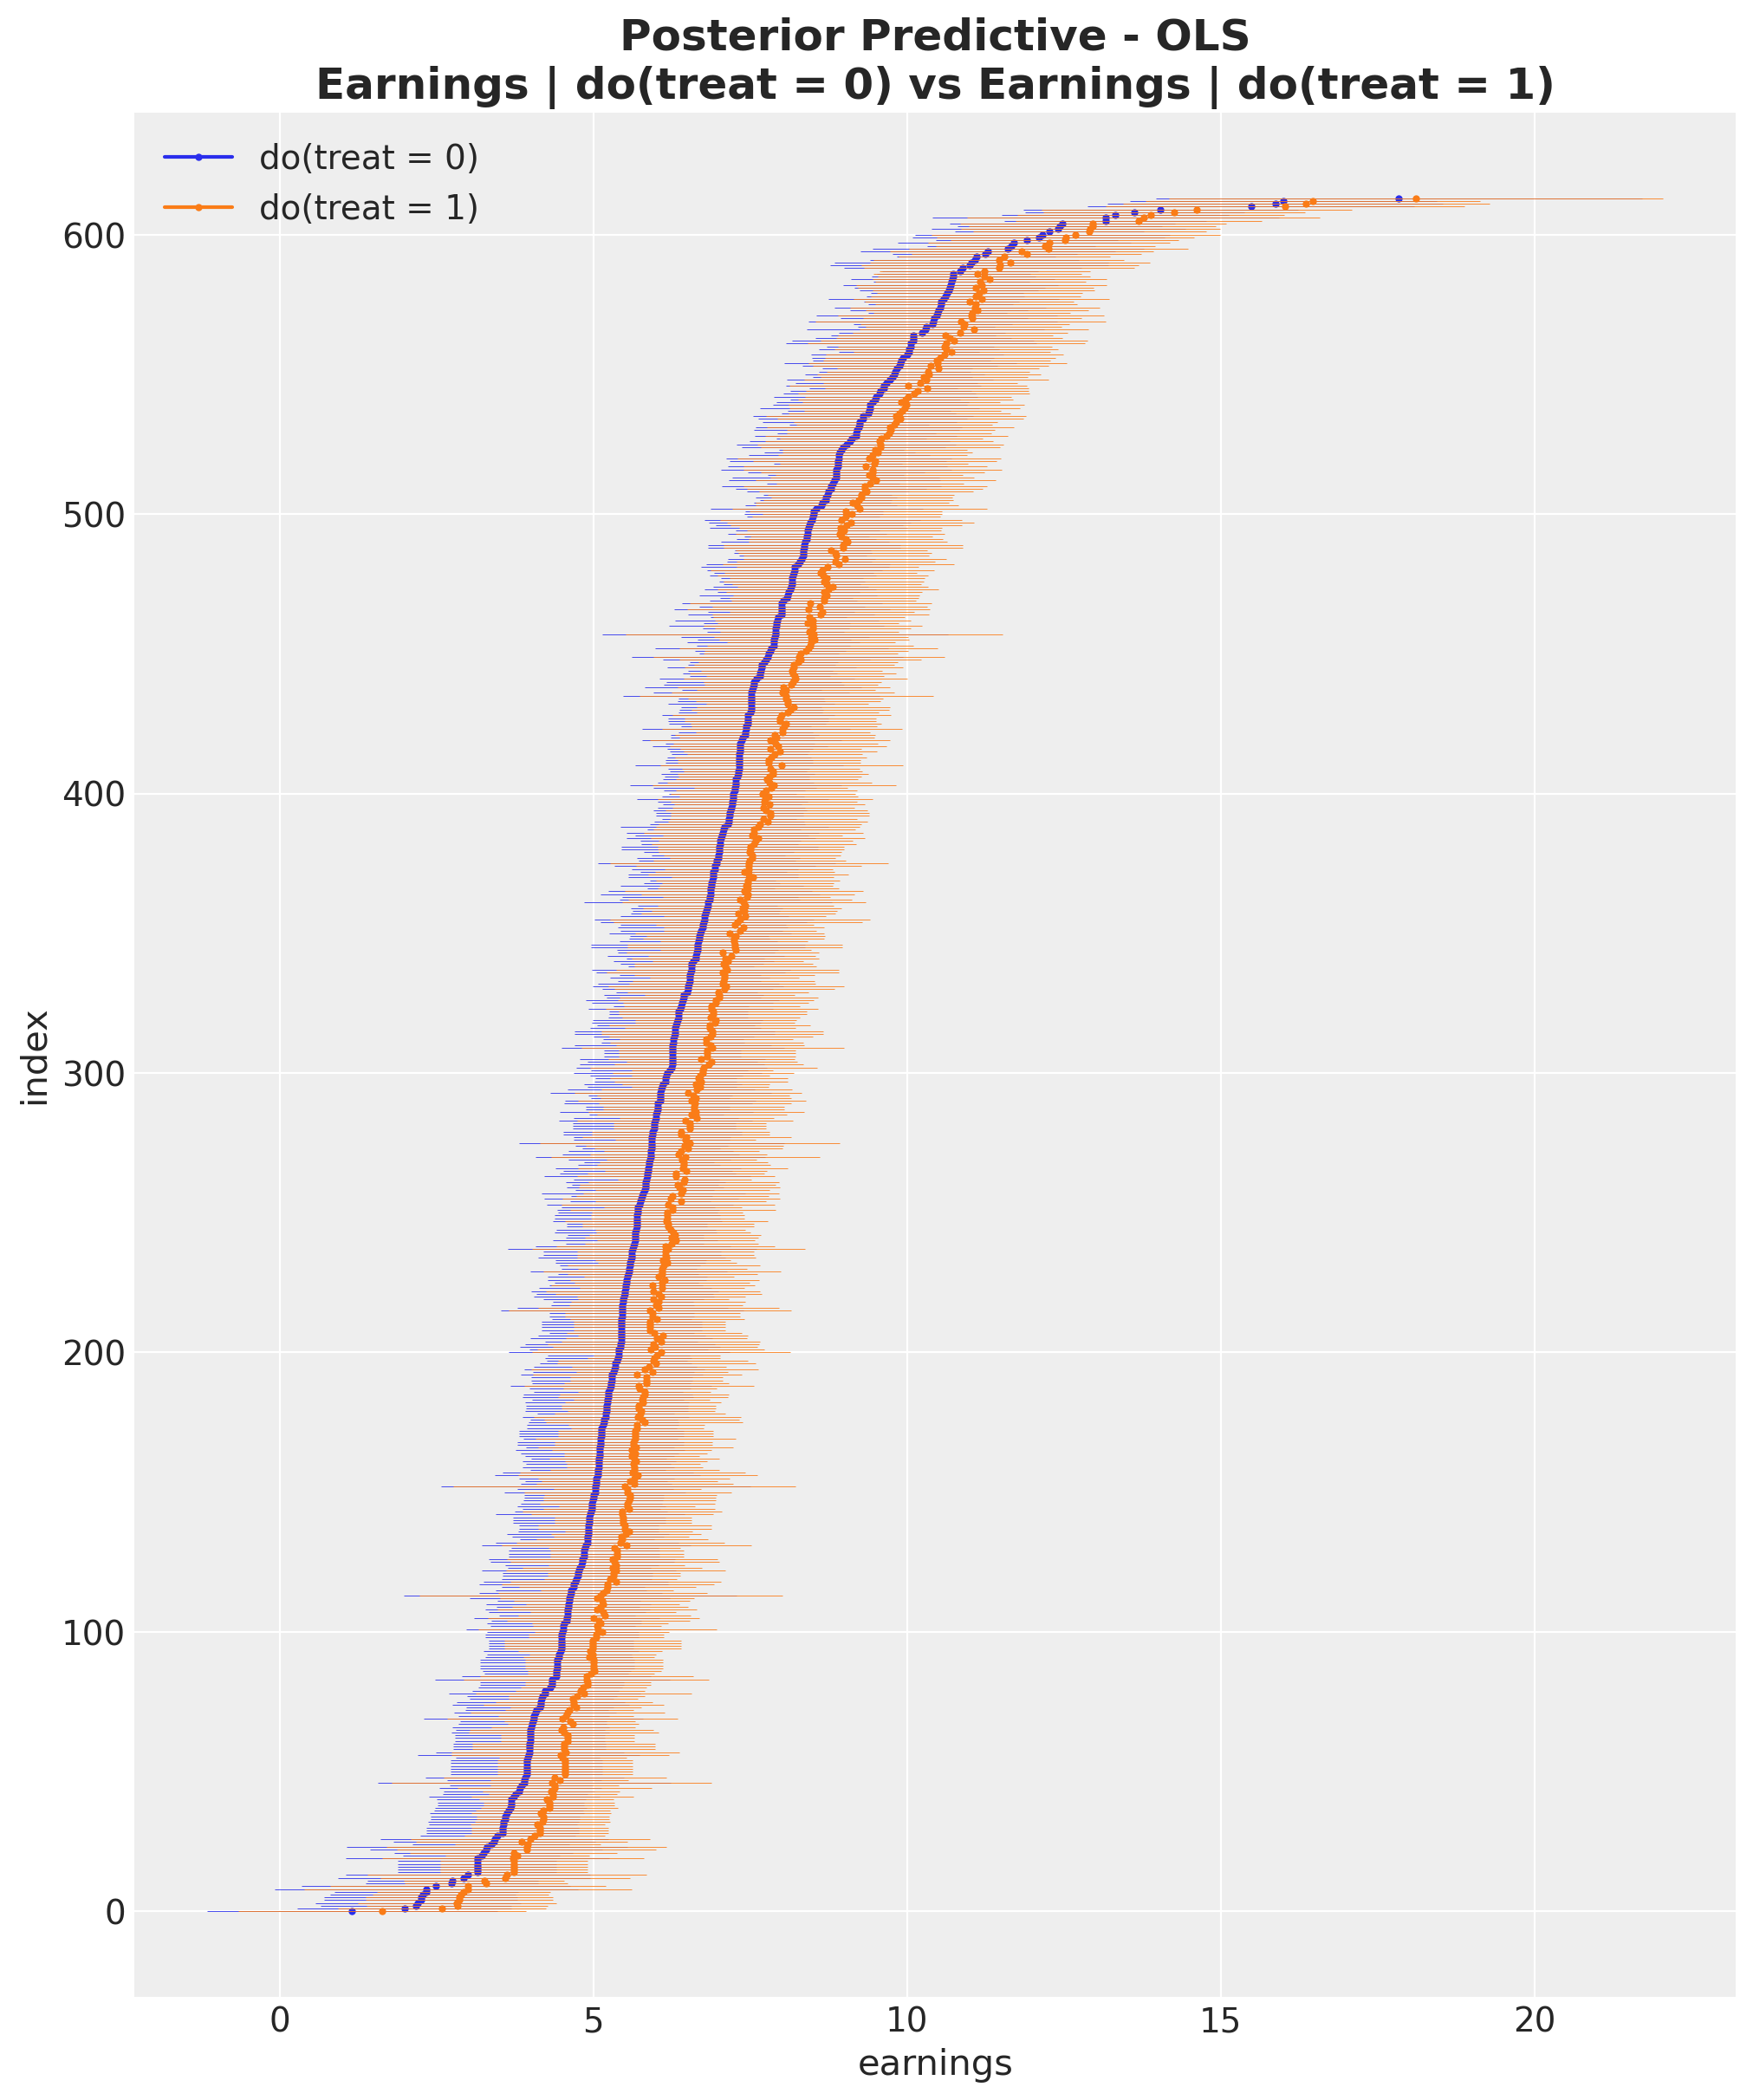

In [25]:
# For visualization purposes, we sort the HDIs by the mean of the HDI
sorted_indices = np.argsort(do_0_hdi.mean(dim="hdi").to_numpy())

fig, ax = plt.subplots(figsize=(10, 12))

for i, row in enumerate(do_0_hdi[sorted_indices]):
    do_0_label = "do(treat = 0)" if i == 0 else None
    ax.hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C0",
    )

    ax.plot(row.mean(), i, marker="o", markersize=2, color="C0", label=do_0_label)

for i, row in enumerate(do_1_hdi[sorted_indices]):
    do_1_label = "do(treat = 1)" if i == 0 else None
    ax.hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C1",
    )

    ax.plot(row.mean(), i, marker="o", markersize=2, color="C1", label=do_1_label)

ax.legend(loc="upper left")
ax.set(
    xlabel="earnings", ylabel="index", title="Posterior Predictive Checks (earnings)"
)
ax.set_title(
    "Posterior Predictive - OLS\nEarnings | do(treat = 0) vs Earnings | do(treat = 1)",
    fontsize=18,
    fontweight="bold",
);

From this visualization, it is clear that the inferred average treatment effect is positive.

We can compute the ATE using the `do` operator by calculating the individual differences between
counterfactual outcomes and then averaging over the entire dataset.

In [26]:
ate = (expected_do_1 - expected_do_0).mean(dim="obs_idx").rename("ate")

This gives us the posterior distribution of the ATE.

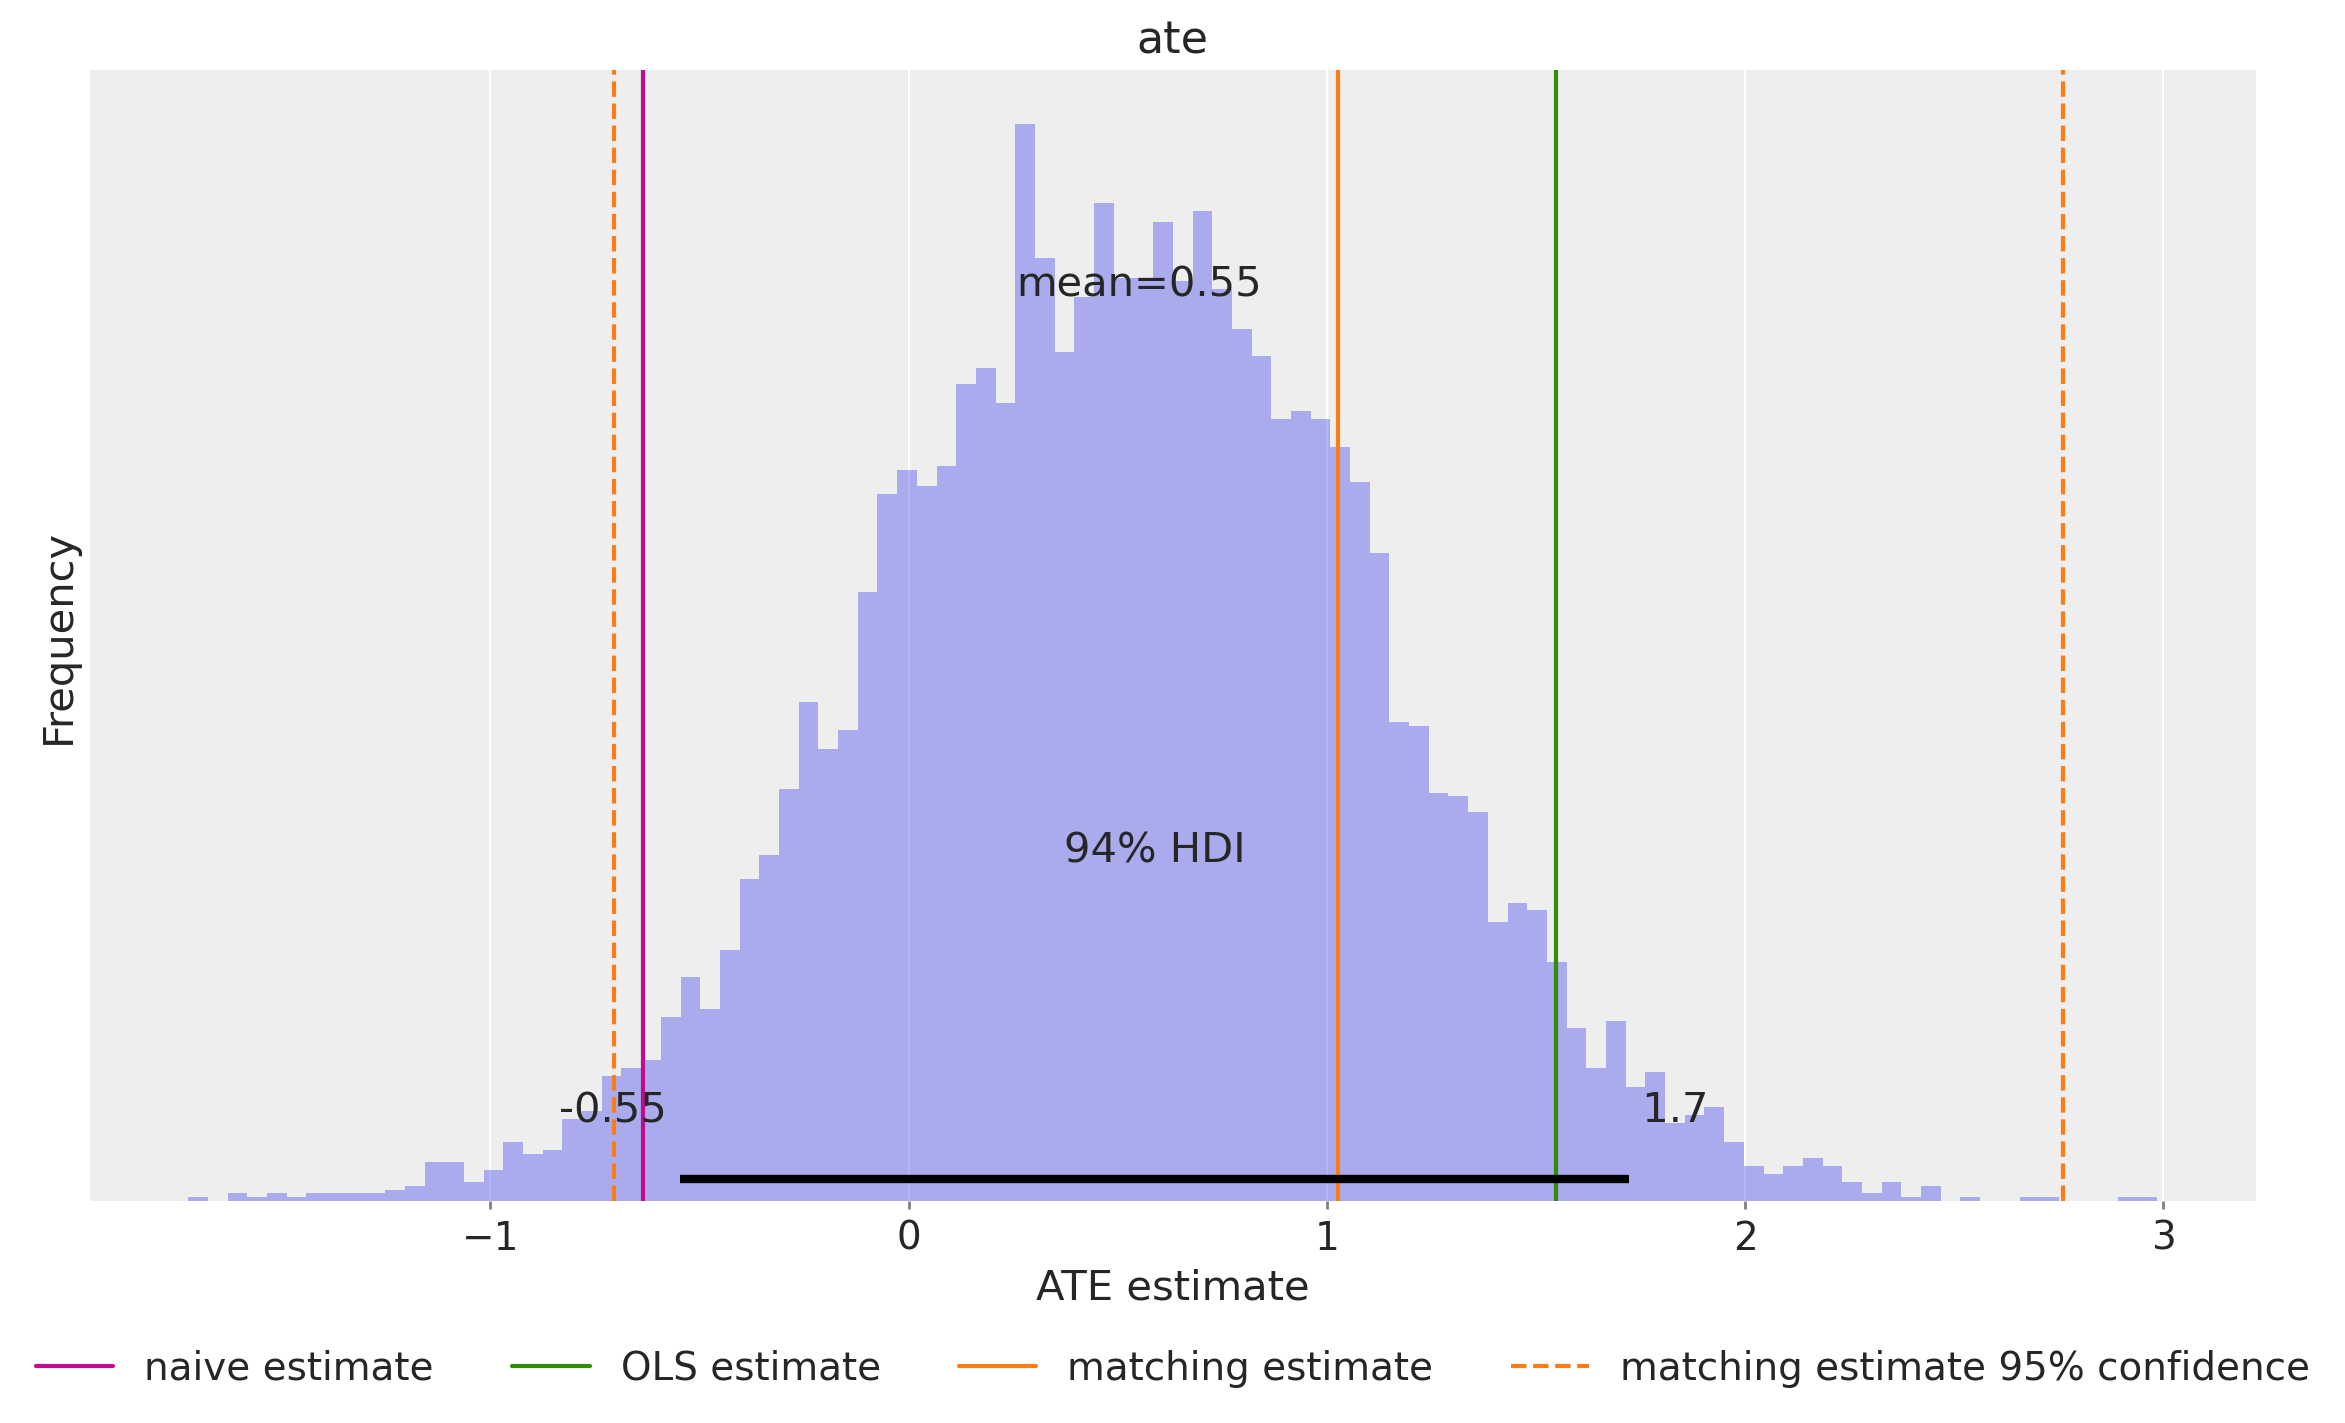

In [27]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(naive_prediction, color="C3", label="naive estimate")
ax.axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax.axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax.axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax.axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(ate, kind="hist", bins=100, ax=ax)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="ATE estimate", ylabel="Frequency");

## ATE Estimation Comparison

We compare the ATE estimation using the coefficient method and the `do` operator.

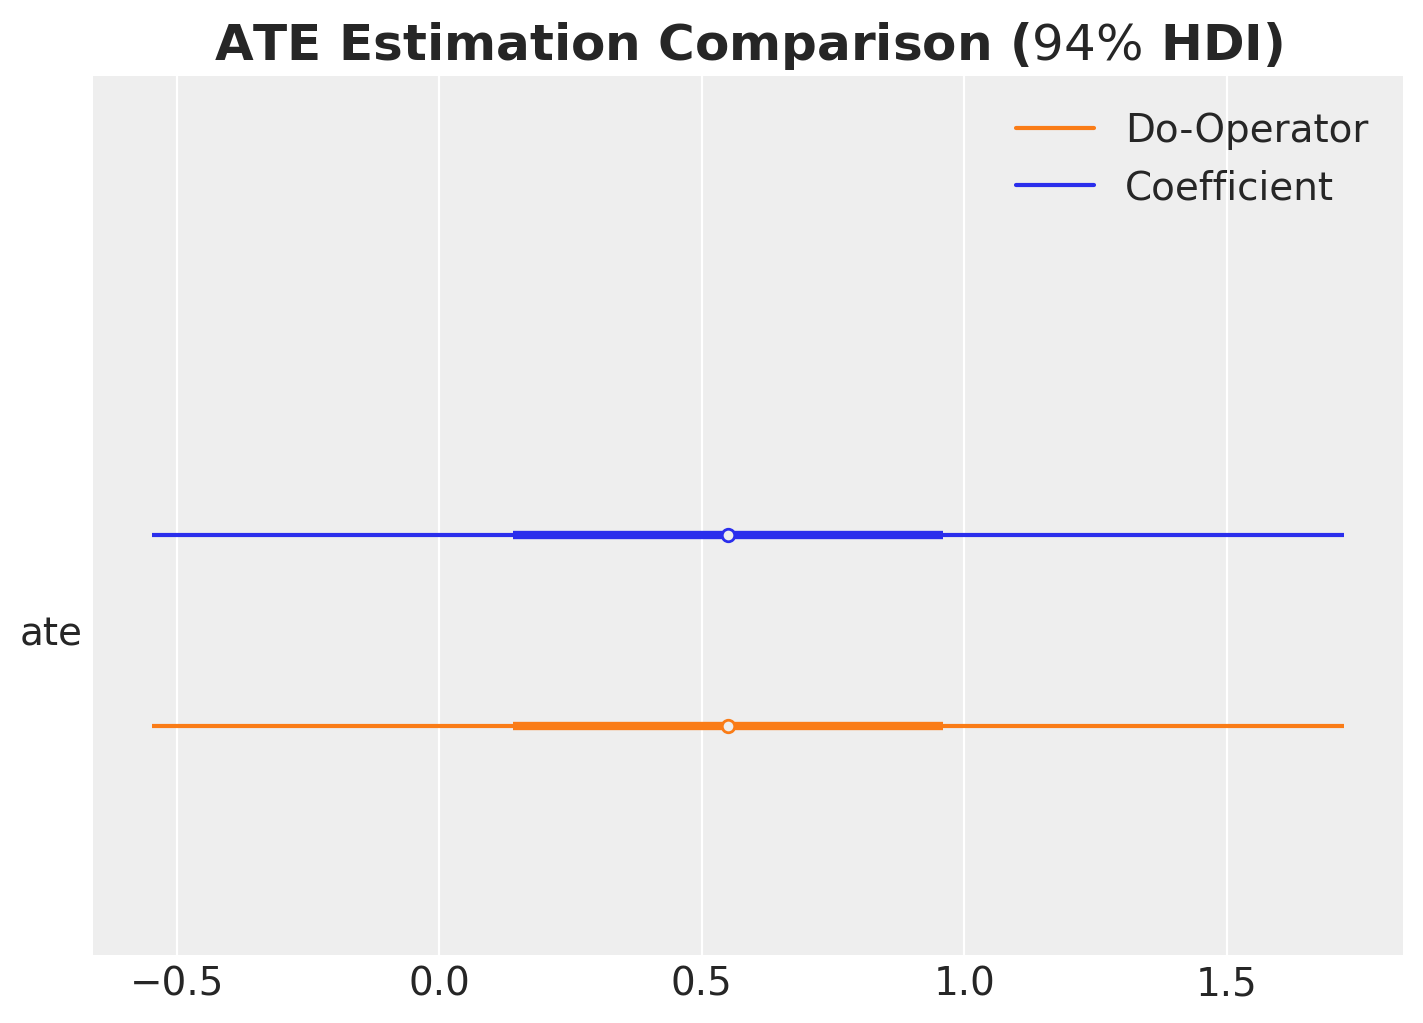

In [28]:
ax, *_ = az.plot_forest(
    data=[idata["posterior"].rename({"beta_treat_earnings": "ate"})["ate"], ate],
    model_names=["Coefficient", "Do-Operator"],
    var_names=["ate"],
    combined=True,
    hdi_prob=0.94,
    figsize=(7, 5),
)
ax.set_title(r"ATE Estimation Comparison ($94\%$ HDI)", fontsize=18, fontweight="bold");

As expected, the two methods yield consistent results, confirming that both approaches
correctly estimate the ATE.

### Generalized Linear Model

Now let's extend our analysis using a generalized linear model that ensures non-negative earnings.
The overall structure remains similar, but we use a different likelihood and parametrization
that better respects the domain constraints of our outcome variable.

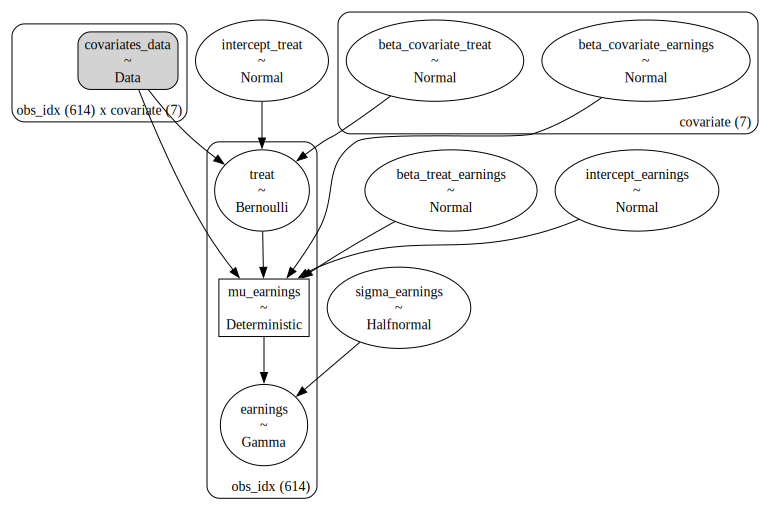

In [29]:
with pm.Model(coords=coords) as glm_earnings_model:
    # TREATMENT MODEL
    # --- Data Containers ---
    covariates_data = pm.Data(
        "covariates_data", covariates_obs, dims=("obs_idx", "covariate")
    )
    # --- Priors ---
    intercept_treat = pm.Normal("intercept_treat", mu=0, sigma=10)
    beta_covariate_treat = pm.Normal(
        "beta_covariate_treat", mu=0, sigma=1, dims=("covariate",)
    )
    # --- Parametrization ---
    logit_p_treat = intercept_treat + pm.math.dot(covariates_data, beta_covariate_treat)
    p_treat = pm.math.sigmoid(logit_p_treat)
    # --- Likelihood ---
    treat = pm.Bernoulli("treat", p=p_treat, dims=("obs_idx",))

    # EARNINGS MODEL
    # --- Priors ---
    intercept_earnings = pm.Normal("intercept_earnings", mu=0, sigma=10)
    beta_treat_earnings = pm.Normal("beta_treat_earnings", mu=0, sigma=1)
    beta_covariate_earnings = pm.Normal(
        "beta_covariate_earnings", mu=0, sigma=1, dims=("covariate",)
    )
    sigma_earnings = pm.HalfNormal("sigma_earnings", sigma=10)
    # --- Parametrization ---
    raw_mu_earnings = (
        intercept_earnings
        + beta_treat_earnings * treat
        + pm.math.dot(covariates_data, beta_covariate_earnings)
    )
    mu_earnings = pm.Deterministic(
        "mu_earnings", pt.softplus(raw_mu_earnings), dims=("obs_idx",)
    )
    # --- Likelihood ---
    pm.Gamma(
        "earnings",
        mu=mu_earnings,
        sigma=sigma_earnings,
        dims=("obs_idx",),
    )

pm.model_to_graphviz(glm_earnings_model)

Let's perform prior predictive checks for the GLM:

Sampling: [beta_covariate_earnings, beta_covariate_treat, beta_treat_earnings, earnings, intercept_earnings, intercept_treat, sigma_earnings, treat]


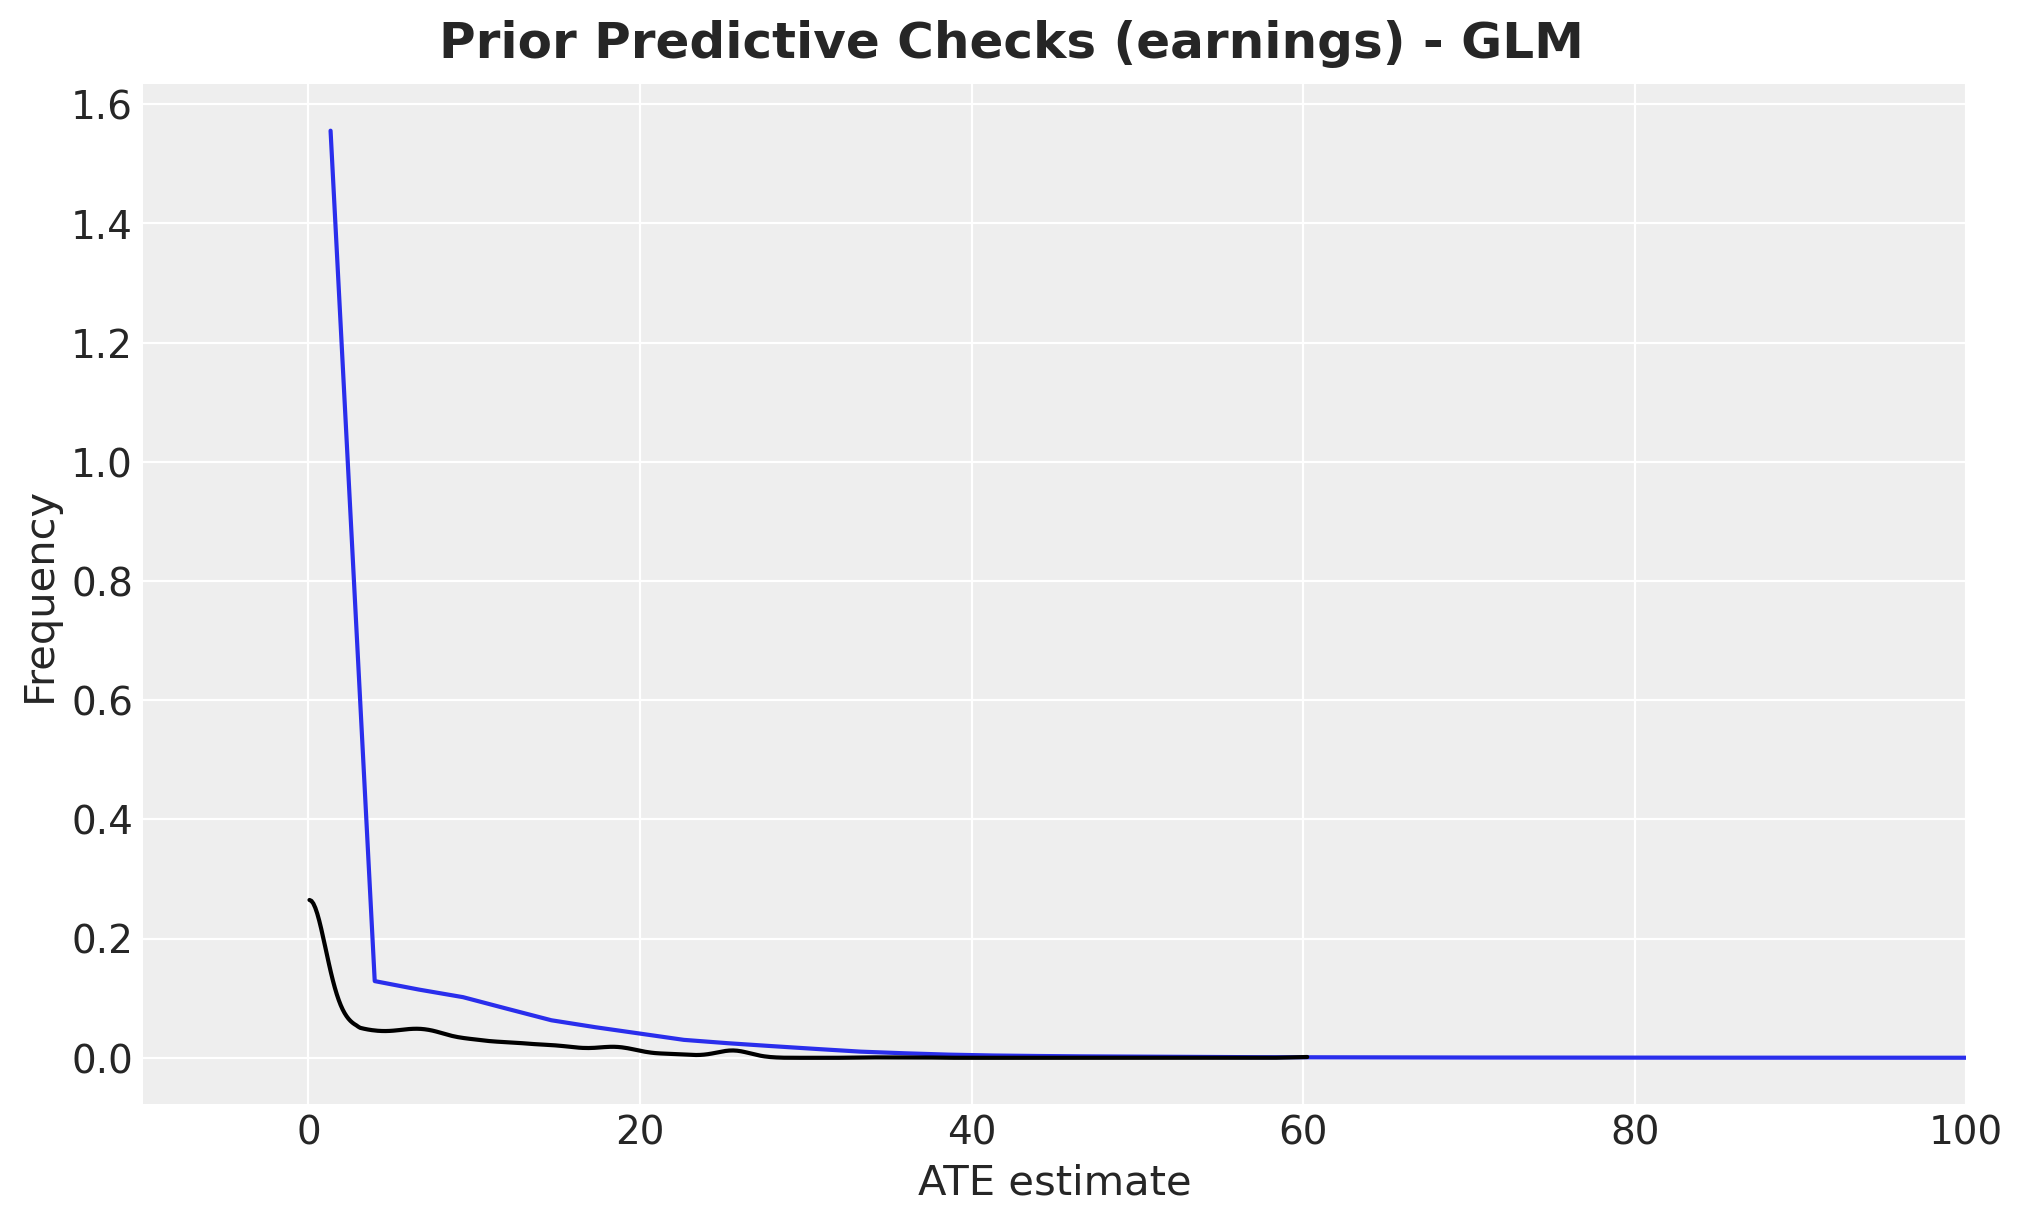

In [30]:
with glm_earnings_model:
    glm_idata = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

fig, ax = plt.subplots()
az.plot_dist(glm_idata["prior"]["earnings"].to_numpy().flatten(), color="C0", ax=ax)
az.plot_dist(earnings_obs, color="black", ax=ax)
ax.set(xlabel="ATE estimate", ylabel="Frequency", xlim=(-10, 100))
fig.suptitle(
    "Prior Predictive Checks (earnings) - GLM", fontsize=18, fontweight="bold"
);

We condition the GLM on the observed data and sample from the posterior distribution using MCMC.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_covariate_earnings, beta_covariate_treat, intercept_treat, beta_treat_earnings, intercept_earnings, sigma_earnings]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
Sampling: [earnings, treat]


Output()

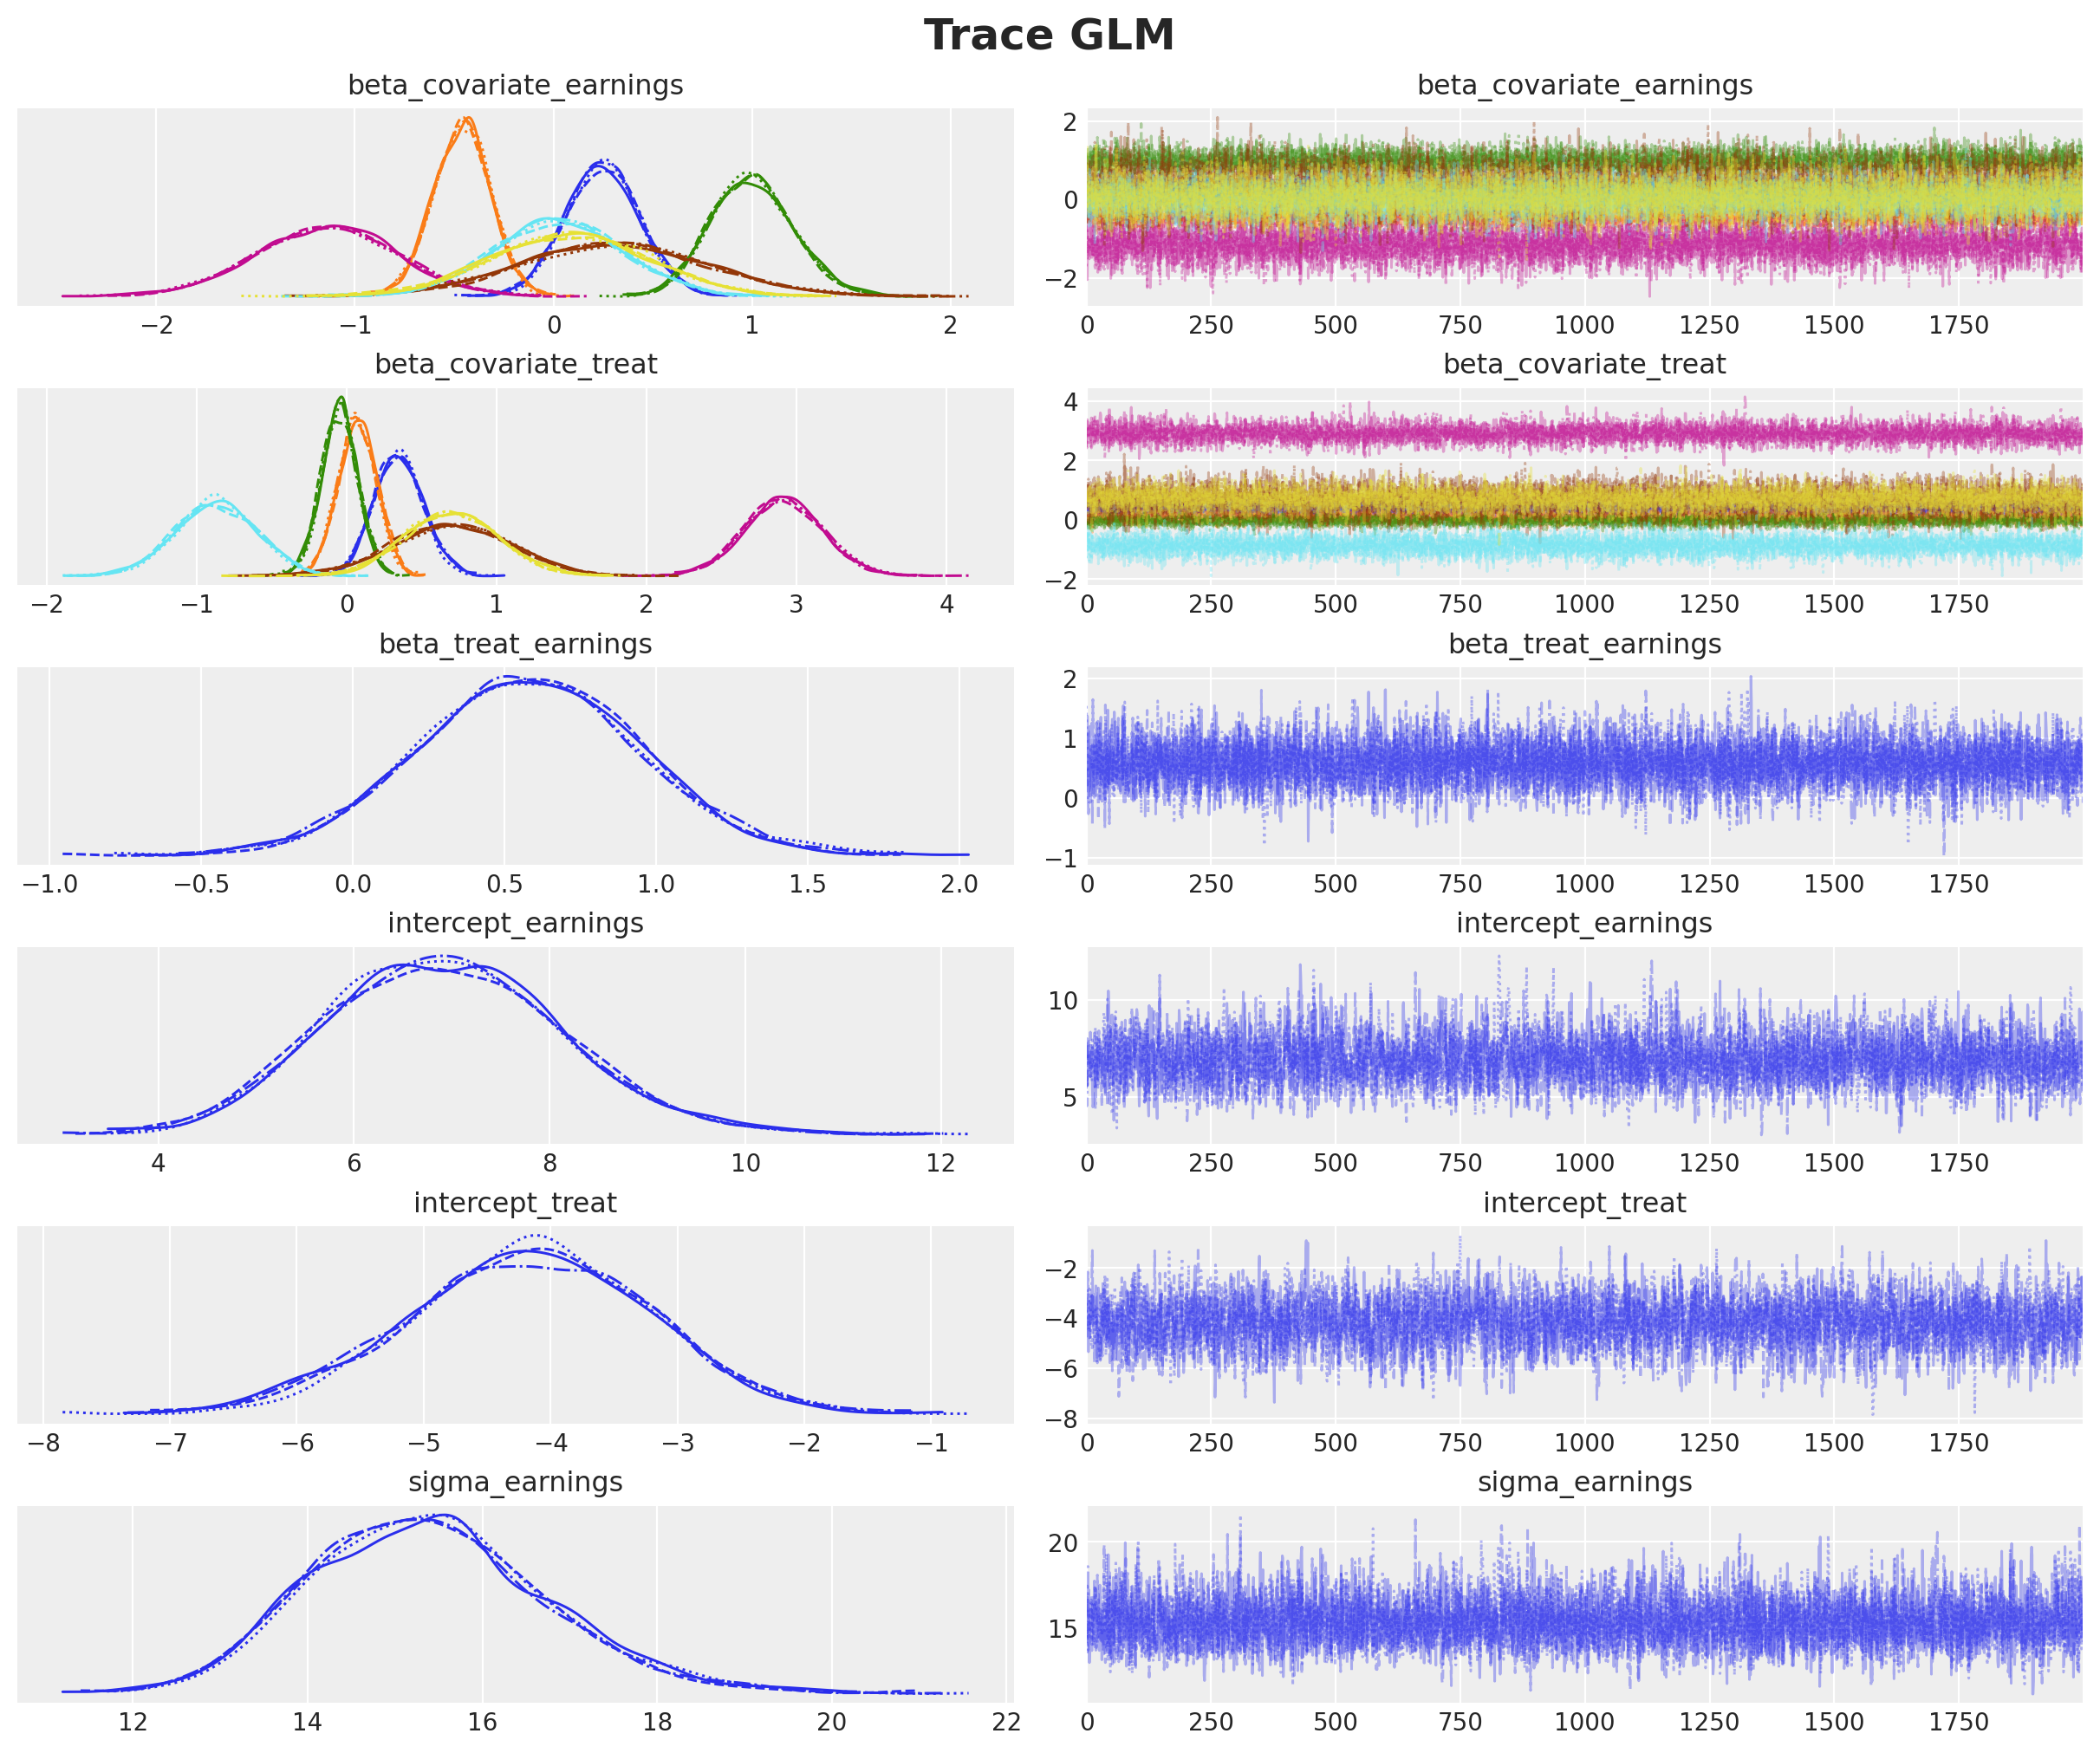

In [41]:
glm_conditioned_earnings_model = observe(
    glm_earnings_model, {"treat": training_obs, "earnings": earnings_obs}
)

with glm_conditioned_earnings_model:
    glm_idata = pm.sample(**sample_kwargs)
    pm.sample_posterior_predictive(
        glm_idata, extend_inferencedata=True, random_seed=rng
    )


axes = az.plot_trace(
    data=glm_idata,
    var_names=["~mu_earnings"],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace GLM", fontsize=18, fontweight="bold");

The trace plots indicate good convergence and mixing across all chains.

Let's examine the posterior predictive distribution to assess model fit.

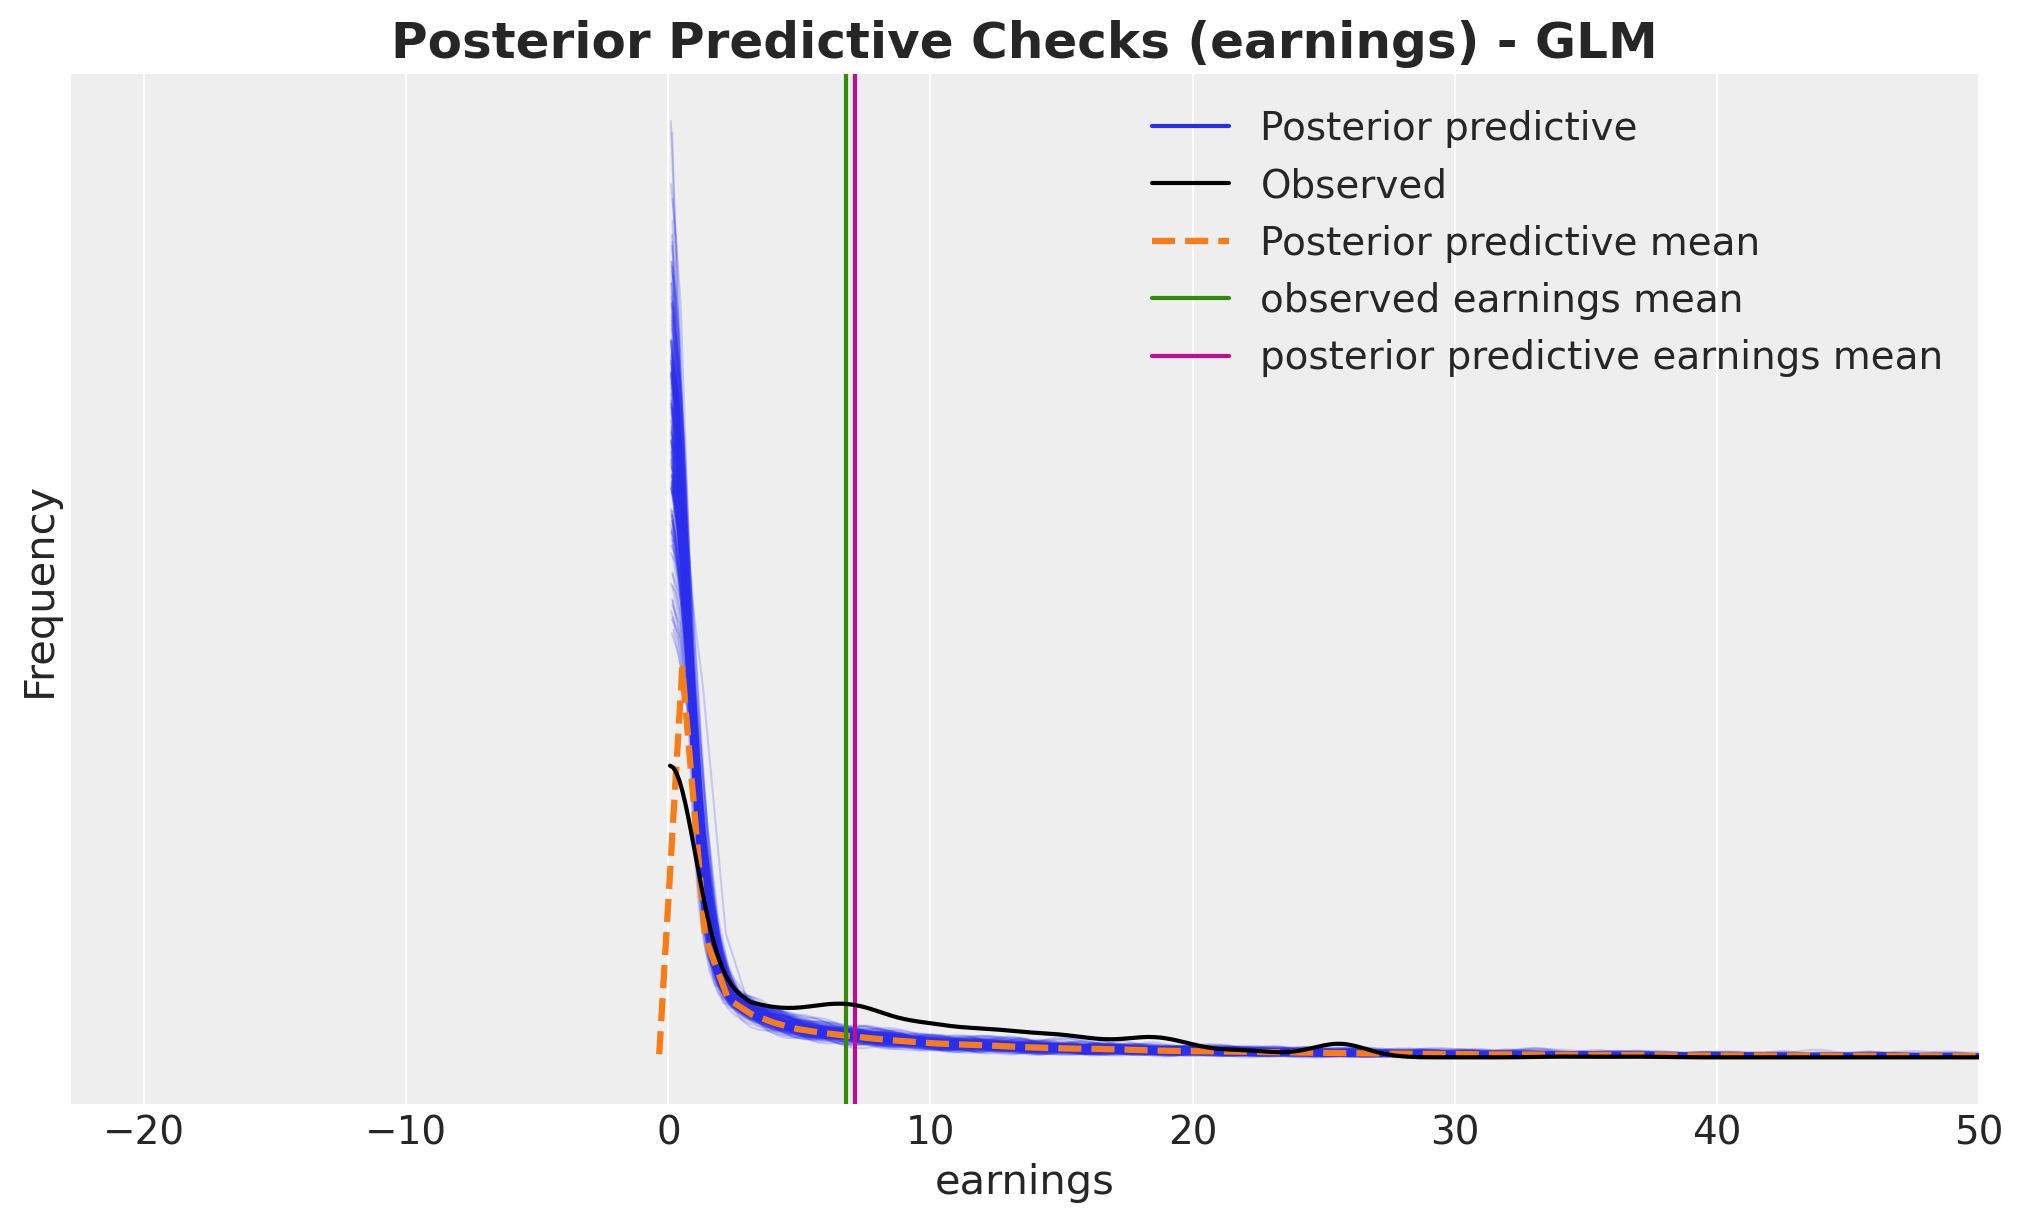

In [32]:
fig, ax = plt.subplots()
az.plot_ppc(glm_idata, var_names=["earnings"], num_pp_samples=200, ax=ax)
ax.axvline(earnings_obs.mean(), color="C2", label="observed earnings mean")
ax.axvline(
    glm_idata["posterior_predictive"]["earnings"].mean().item(),
    color="C3",
    label="posterior predictive earnings mean",
)
ax.legend()
ax.set(xlabel="earnings", ylabel="Frequency", xlim=(None, 50))
ax.set_title(
    "Posterior Predictive Checks (earnings) - GLM", fontsize=18, fontweight="bold"
);

The GLM provides a much better fit than the linear model, with predictions that align more
closely with the observed data distribution.

Now let's compute the counterfactual outcomes using the `do` operator, just as we did for
the linear model.

In [33]:
glm_do_0_earnings_model = do(
    glm_conditioned_earnings_model, {"treat": np.zeros(shape=(n_obs,), dtype=np.int32)}
)
glm_do_1_earnings_model = do(
    glm_conditioned_earnings_model, {"treat": np.ones(shape=(n_obs,), dtype=np.int32)}
)

with glm_do_0_earnings_model:
    glm_do_0_idata = pm.sample_posterior_predictive(
        glm_idata, random_seed=rng, var_names=["mu_earnings"]
    )

with glm_do_1_earnings_model:
    glm_do_1_idata = pm.sample_posterior_predictive(
        glm_idata, random_seed=rng, var_names=["mu_earnings"]
    )


glm_expected_do_1 = glm_do_1_idata["posterior_predictive"]["mu_earnings"]

glm_expected_do_0 = glm_do_0_idata["posterior_predictive"]["mu_earnings"]

Sampling: []


Output()

Sampling: []


Output()

Let's visualize the posterior predictive distributions for both counterfactual scenarios.

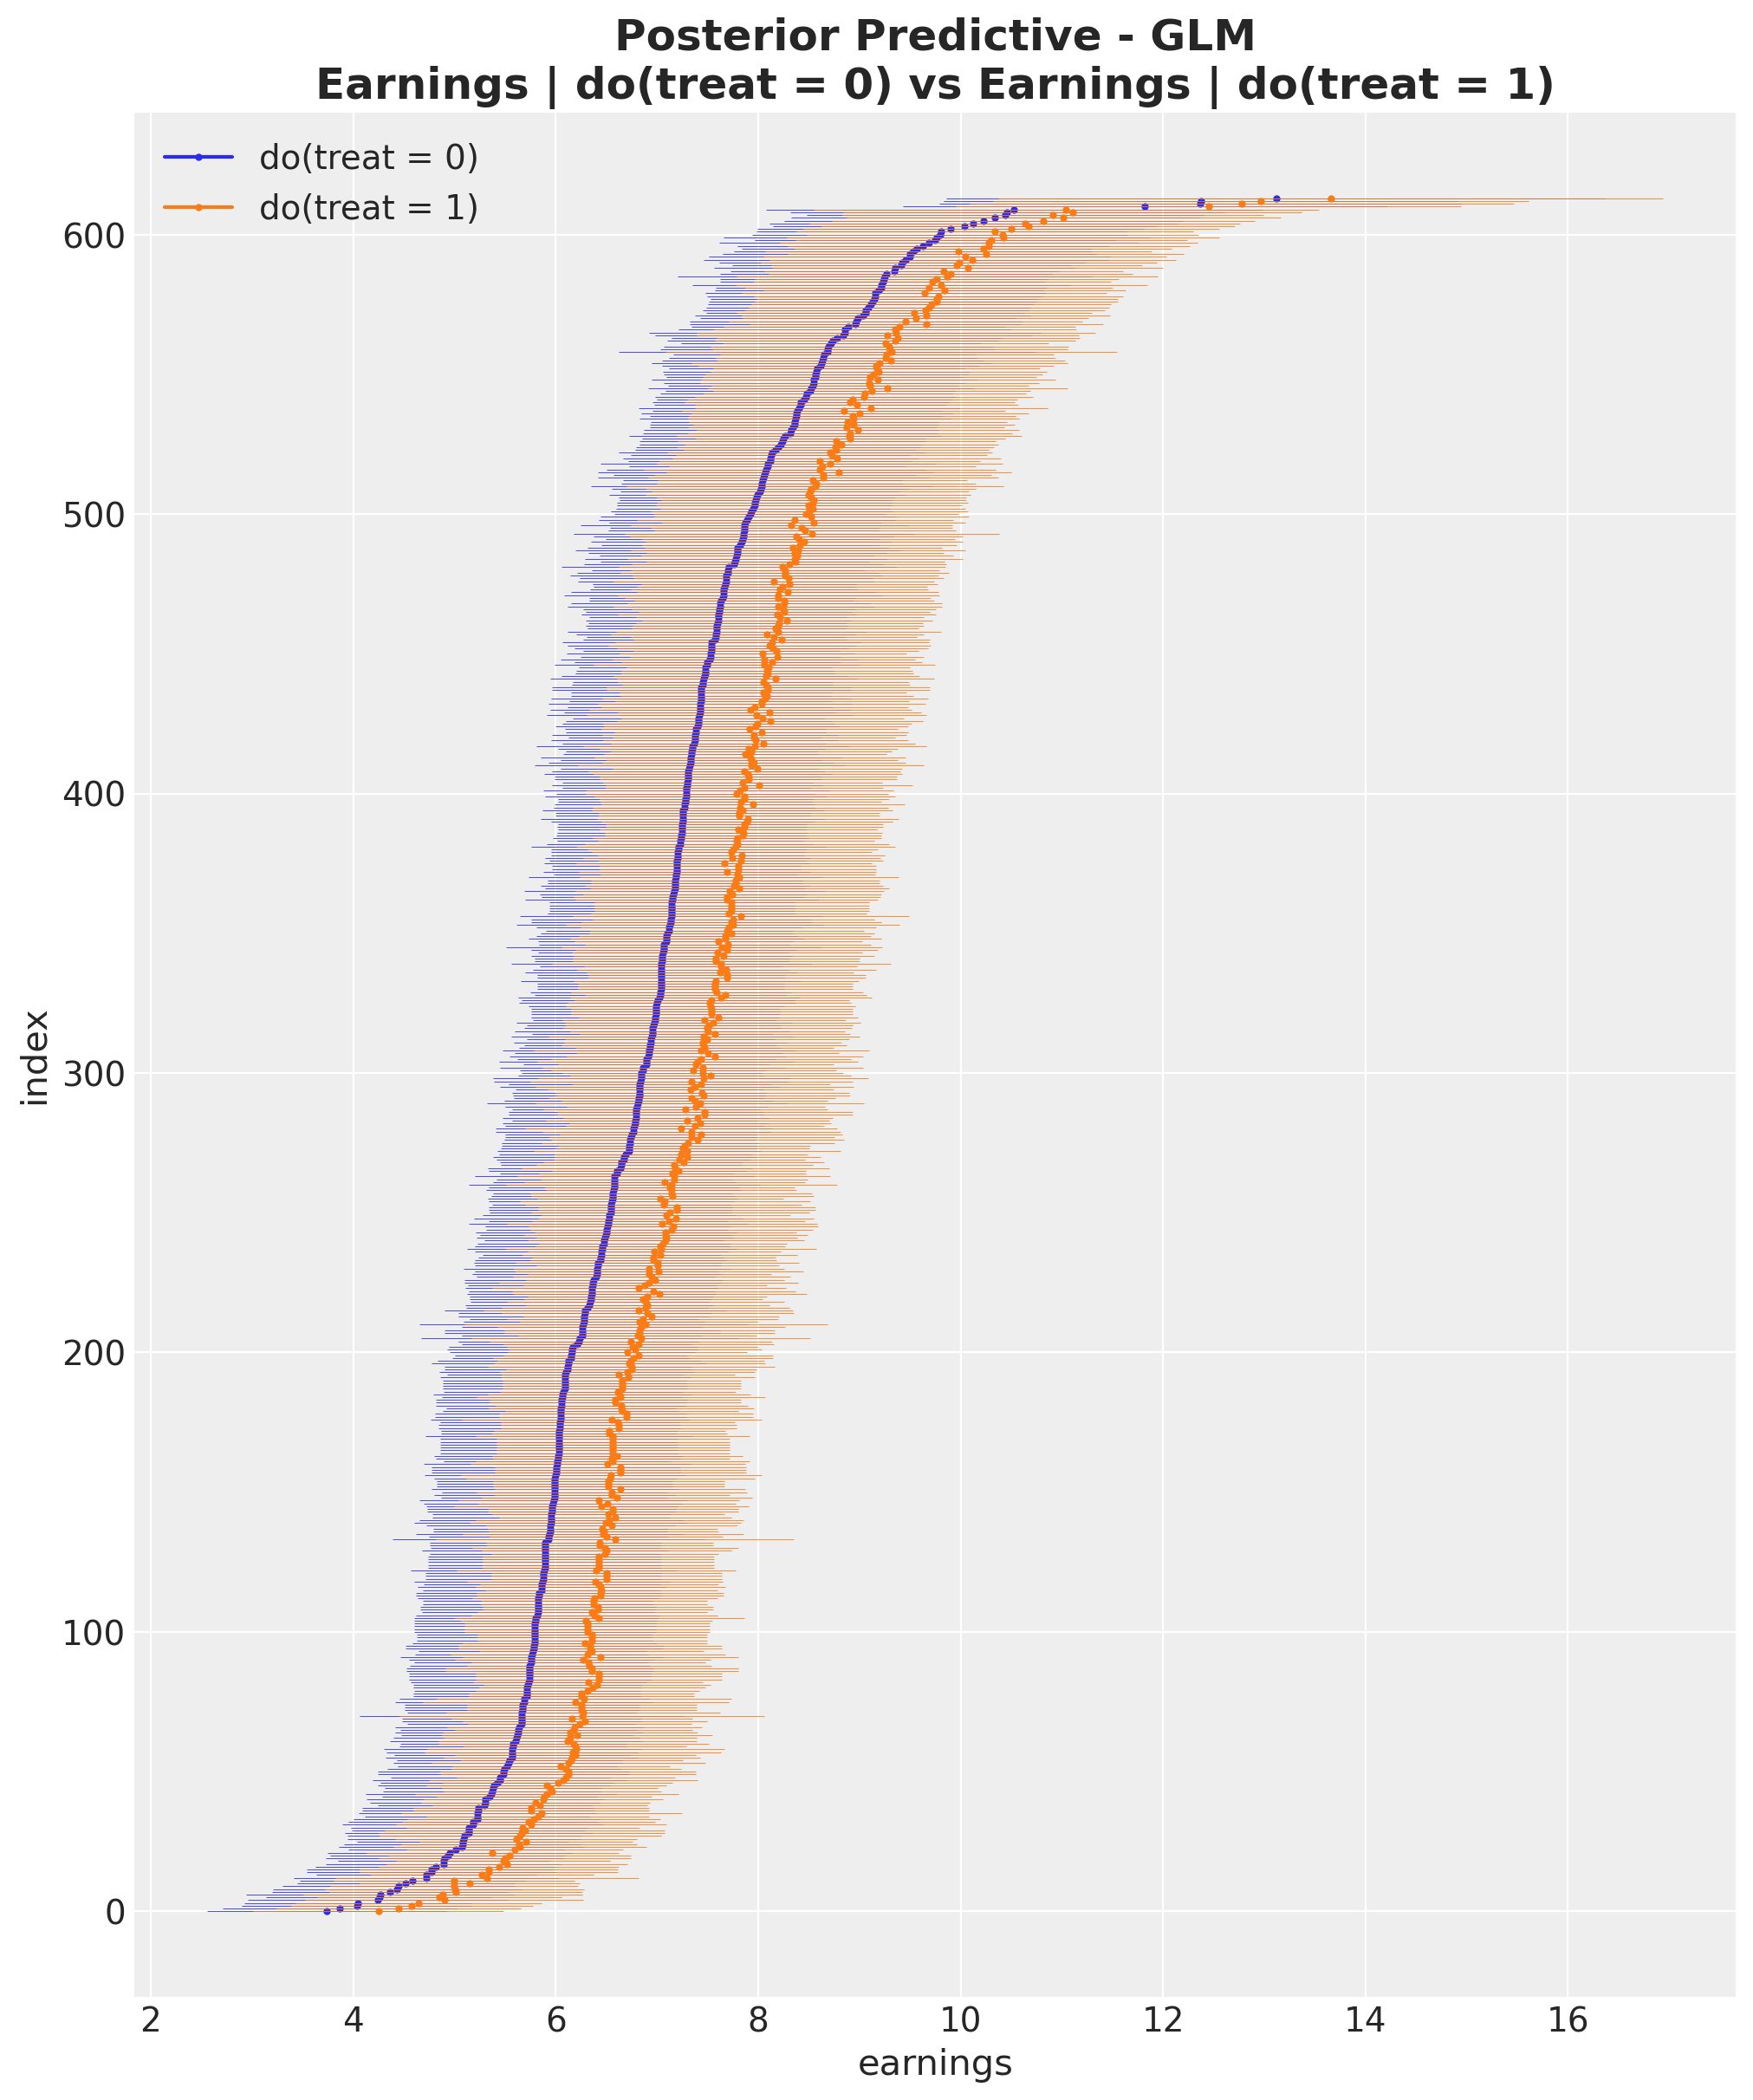

In [34]:
glm_do_0_hdi = az.hdi(glm_expected_do_0)["mu_earnings"]
glm_do_1_hdi = az.hdi(glm_expected_do_1)["mu_earnings"]

glm_sorted_indices = np.argsort(glm_do_0_hdi.mean(dim="hdi").to_numpy())

fig, ax = plt.subplots(figsize=(10, 12))

for i, row in enumerate(glm_do_0_hdi[glm_sorted_indices]):
    do_0_label = "do(treat = 0)" if i == 0 else None
    ax.hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C0",
    )

    ax.plot(row.mean(), i, marker="o", markersize=2, color="C0", label=do_0_label)

for i, row in enumerate(glm_do_1_hdi[glm_sorted_indices]):
    do_1_label = "do(treat = 1)" if i == 0 else None
    ax.hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C1",
    )

    ax.plot(row.mean(), i, marker="o", markersize=2, color="C1", label=do_1_label)

ax.legend(loc="upper left")
ax.set(
    xlabel="earnings", ylabel="index", title="Posterior Predictive Checks (earnings)"
)
ax.set_title(
    "Posterior Predictive - GLM\nEarnings | do(treat = 0) vs Earnings | do(treat = 1)",
    fontsize=18,
    fontweight="bold",
);

For easier comparison, let's plot the posterior predictive distributions from both models side by side.

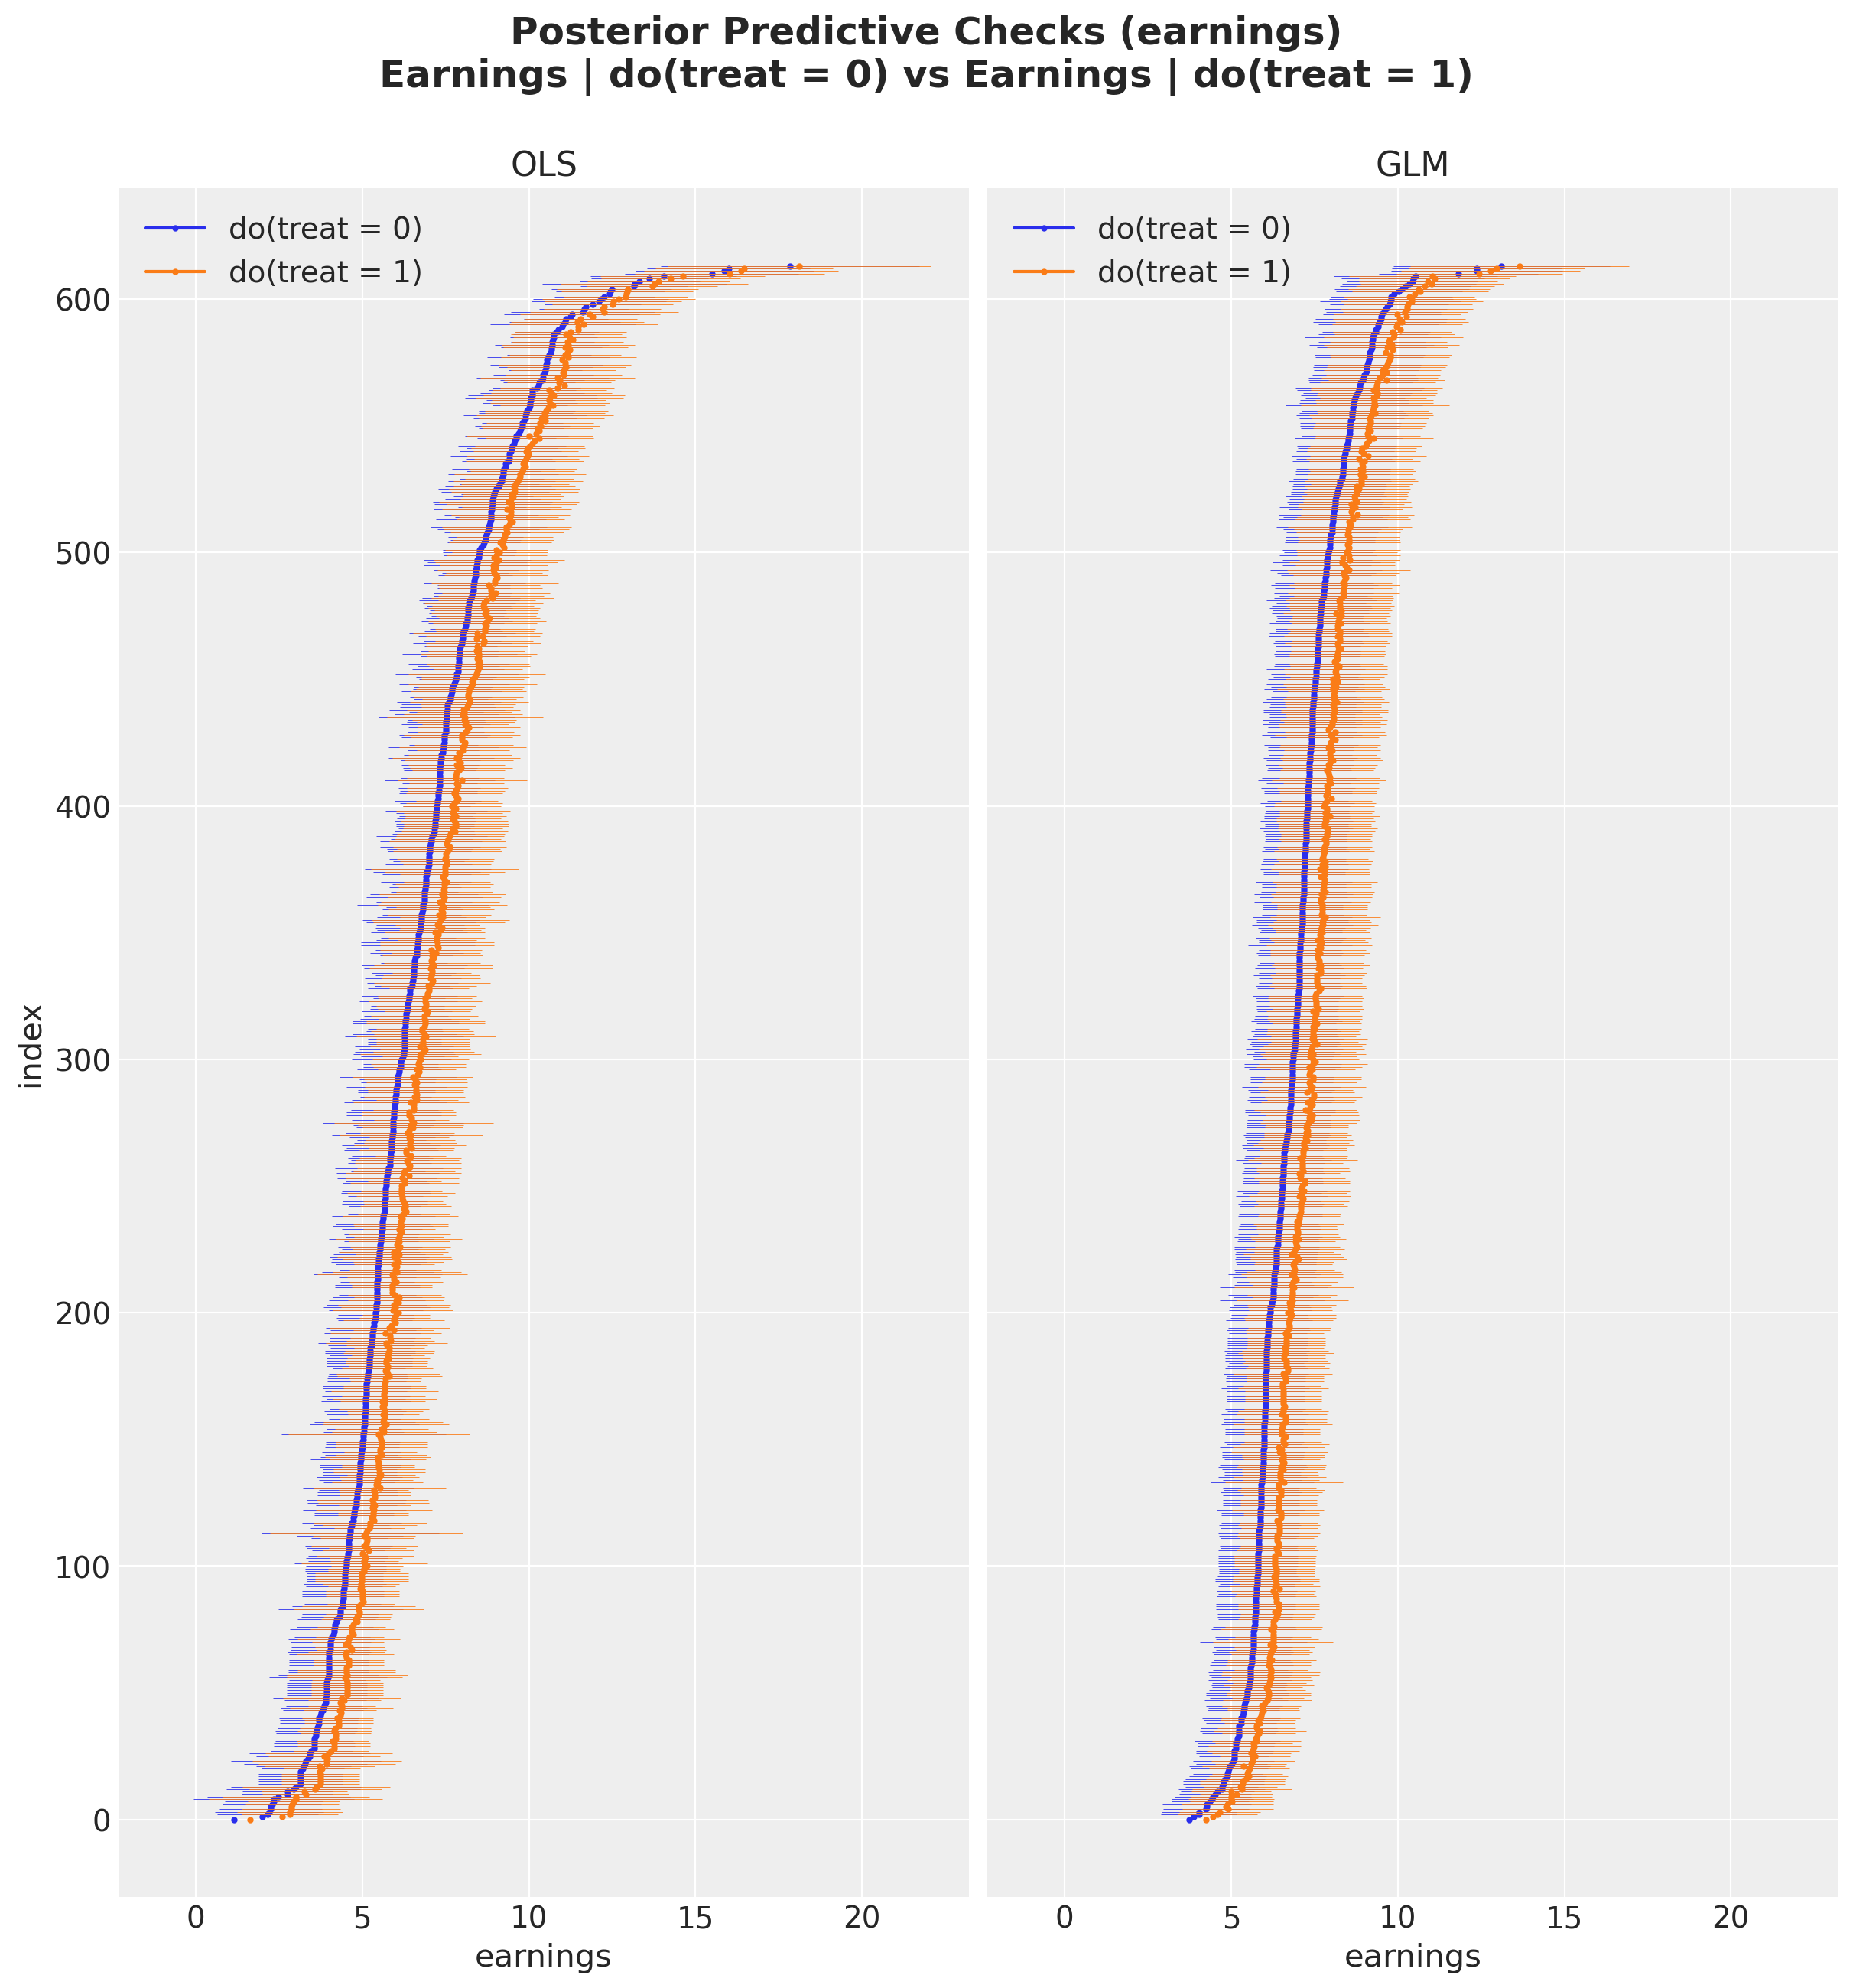

In [ ]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 12),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, row in enumerate(do_0_hdi[sorted_indices]):
    do_0_label = "do(treat = 0)" if i == 0 else None
    ax[0].hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C0",
    )

    ax[0].plot(row.mean(), i, marker="o", markersize=2, color="C0", label=do_0_label)

for i, row in enumerate(do_1_hdi[sorted_indices]):
    do_1_label = "do(treat = 1)" if i == 0 else None
    ax[0].hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C1",
    )

    ax[0].plot(row.mean(), i, marker="o", markersize=2, color="C1", label=do_1_label)

ax[0].legend(loc="upper left")
ax[0].set(xlabel="earnings", ylabel="index", title="OLS")

for i, row in enumerate(glm_do_0_hdi[glm_sorted_indices]):
    do_0_label = "do(treat = 0)" if i == 0 else None
    ax[1].hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C0",
    )

    ax[1].plot(row.mean(), i, marker="o", markersize=2, color="C0", label=do_0_label)


for i, row in enumerate(glm_do_1_hdi[glm_sorted_indices]):
    do_1_label = "do(treat = 1)" if i == 0 else None
    ax[1].hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C1",
    )

    ax[1].plot(row.mean(), i, marker="o", markersize=2, color="C1", label=do_1_label)

ax[1].legend(loc="upper left")
ax[1].set(xlabel="earnings", title="GLM")

fig.suptitle(
    "Posterior Predictive Checks (earnings)\nEarnings | do(treat = 0) vs Earnings | do(treat = 1)",  # noqa: E501
    fontsize=18,
    fontweight="bold",
    y=1.07,
);

By visual inspection, we can see that the GLM produces tighter credible intervals than the OLS
model, suggesting lower variance in the ATE estimate.

We now compute the ATE using the same approach as before.

In [36]:
glm_ate = (glm_expected_do_1 - glm_expected_do_0).mean(dim="obs_idx").rename("ate")

**Remark**: With generalized linear models, the ATE can theoretically be computed from the
coefficient, but the computation is more complex due to the non-linear link function. For
details, see [Causal inference with gamma regression or: The problem is with the link function,
not the likelihood (Part 6 of the GLM and causal inference series.)](https://solomonkurz.netlify.app/blog/2023-05-14-causal-inference-with-gamma-regression-or-the-problem-is-with-the-link-function-not-the-likelihood/)

Let's visualize the results and compare them with the previous model.

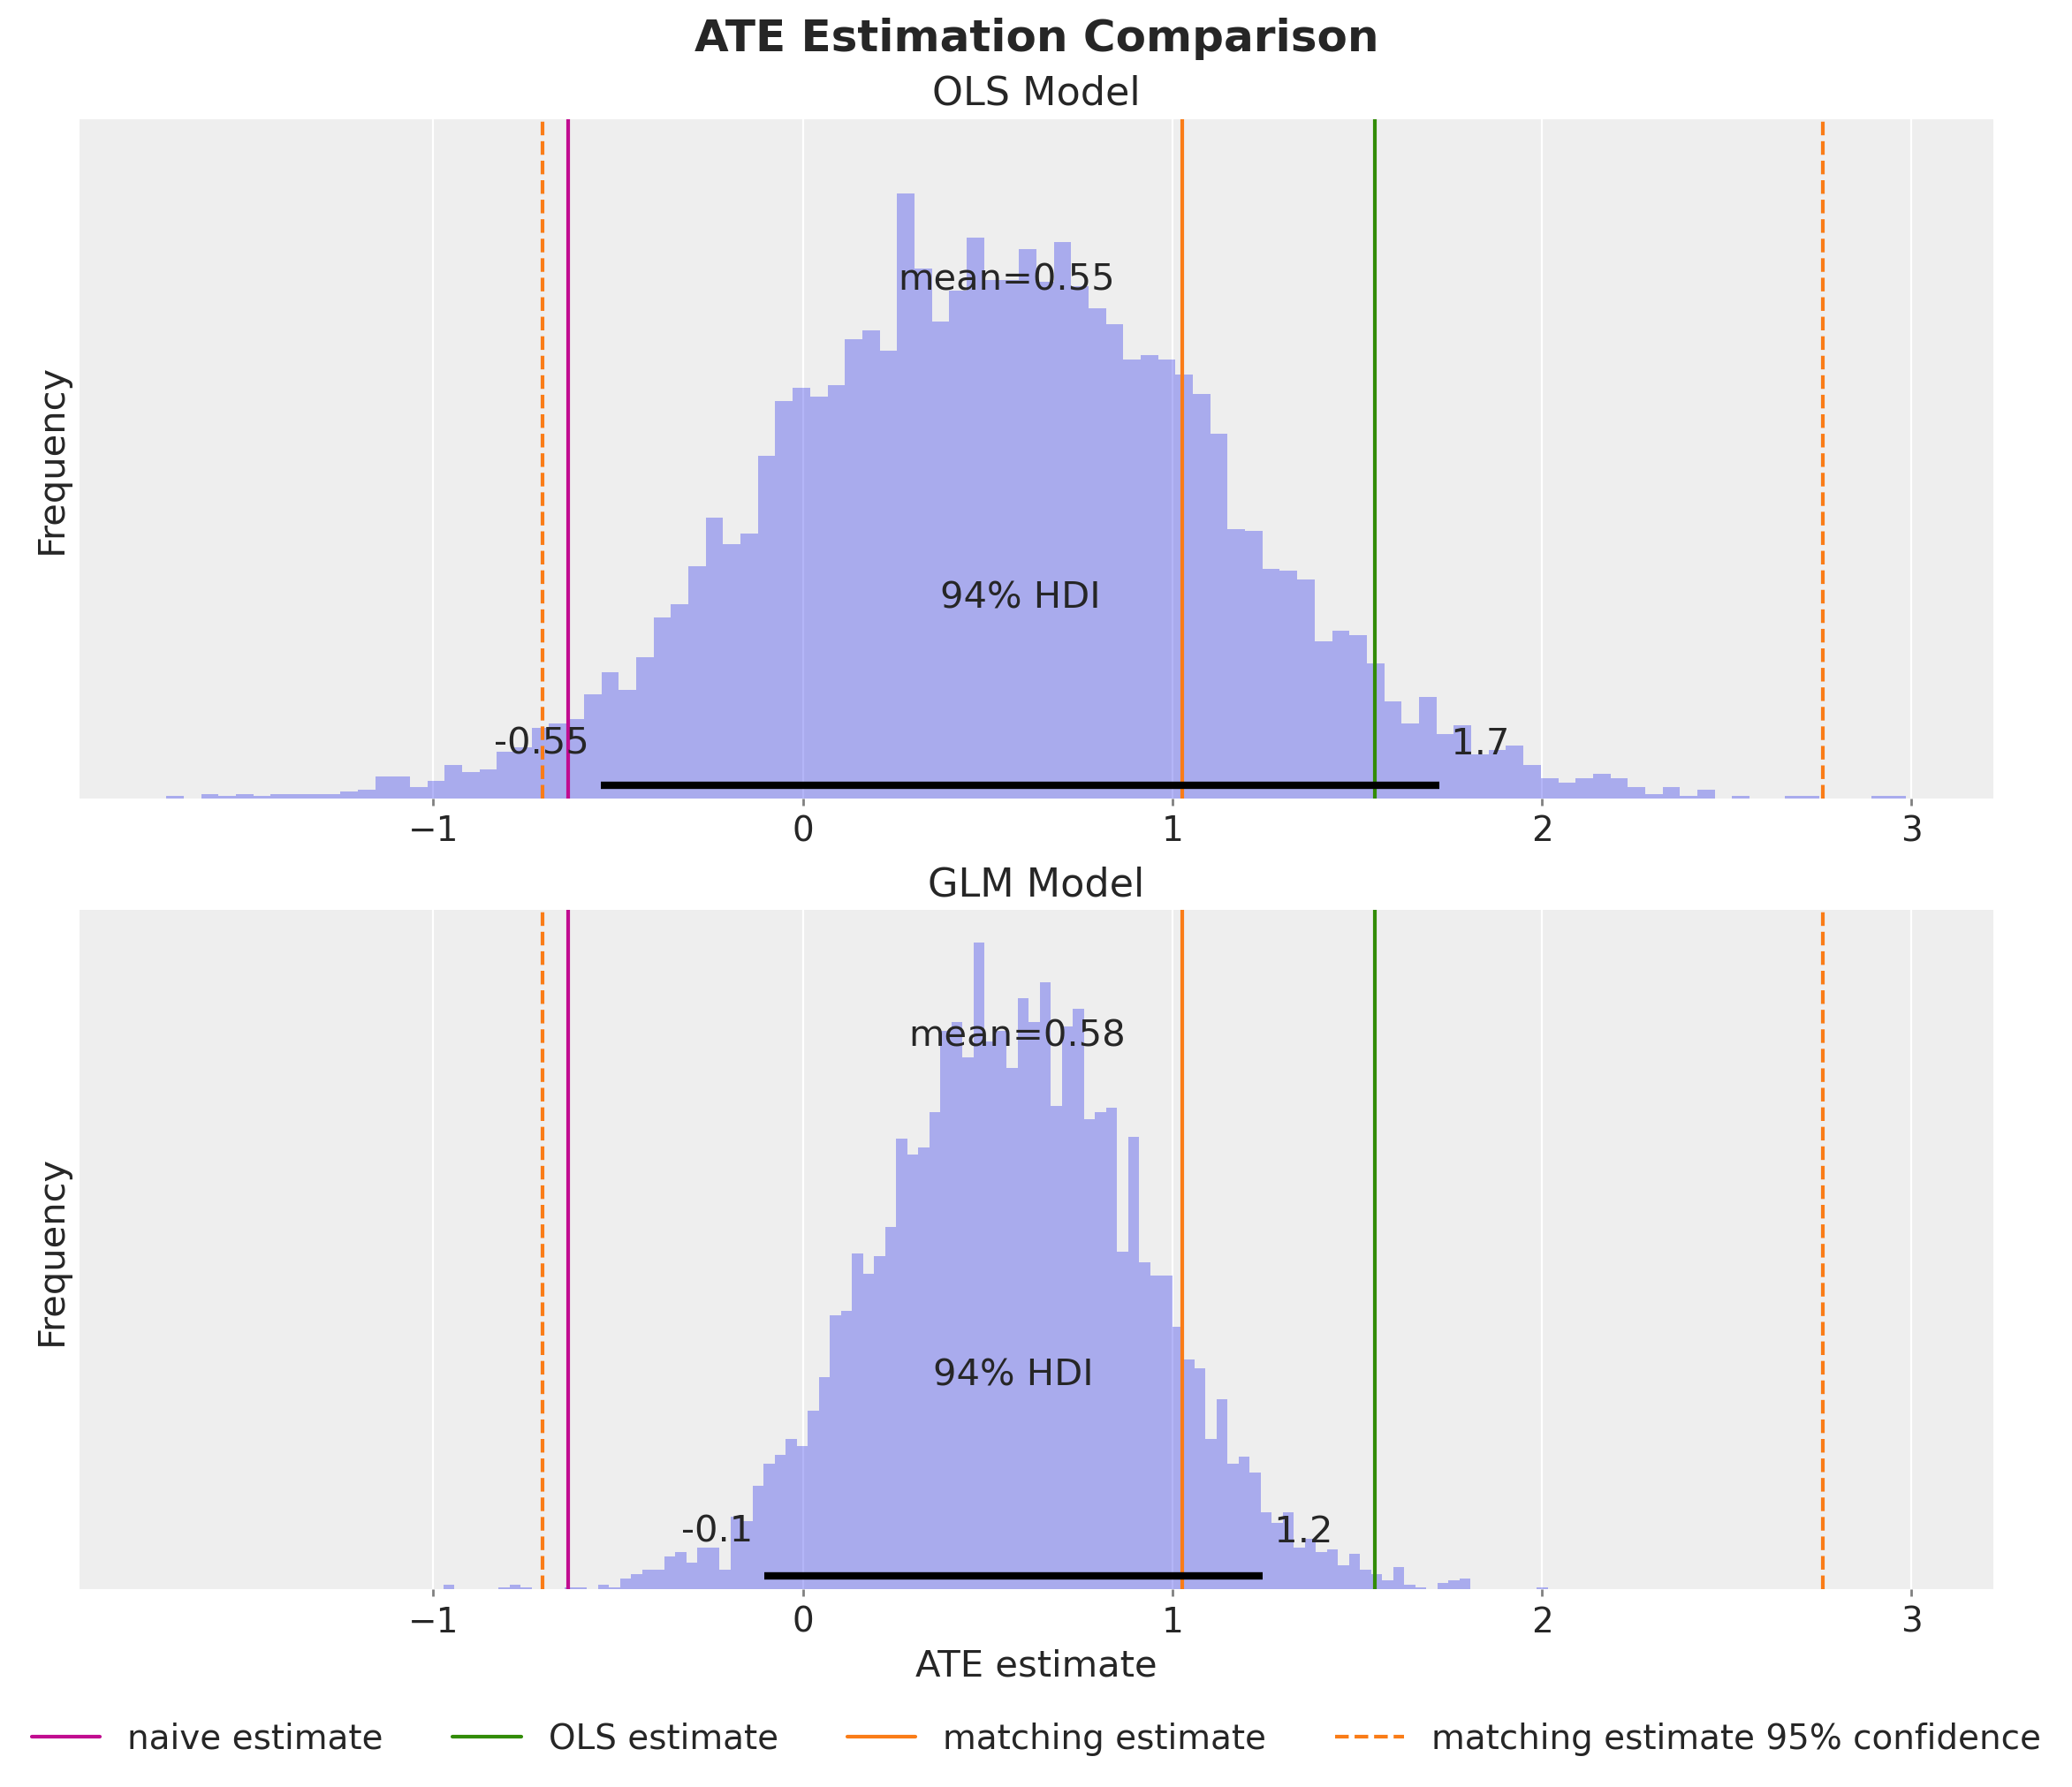

In [37]:
fig, ax = plt.subplots(
    nrows=2,
    figsize=(12, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].axvline(naive_prediction, color="C3", label="naive estimate")
ax[0].axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax[0].axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax[0].axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax[0].axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(ate, kind="hist", bins=100, color="C0", ax=ax[0])
ax[0].set(title="OLS Model", ylabel="Frequency")


ax[1].axvline(naive_prediction, color="C3", label="naive estimate")
ax[1].axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax[1].axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax[1].axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax[1].axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(glm_ate, kind="hist", bins=100, color="C0", ax=ax[1])
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
ax[1].set(title="GLM Model", xlabel="ATE estimate", ylabel="Frequency")
fig.suptitle("ATE Estimation Comparison", fontsize=18, fontweight="bold");

We obtain a very similar posterior mean, but the GLM provides estimates with lower variance,
reflecting the improved model fit.

Let's perform a final comparison of all the methods we've used to compute the ATE.

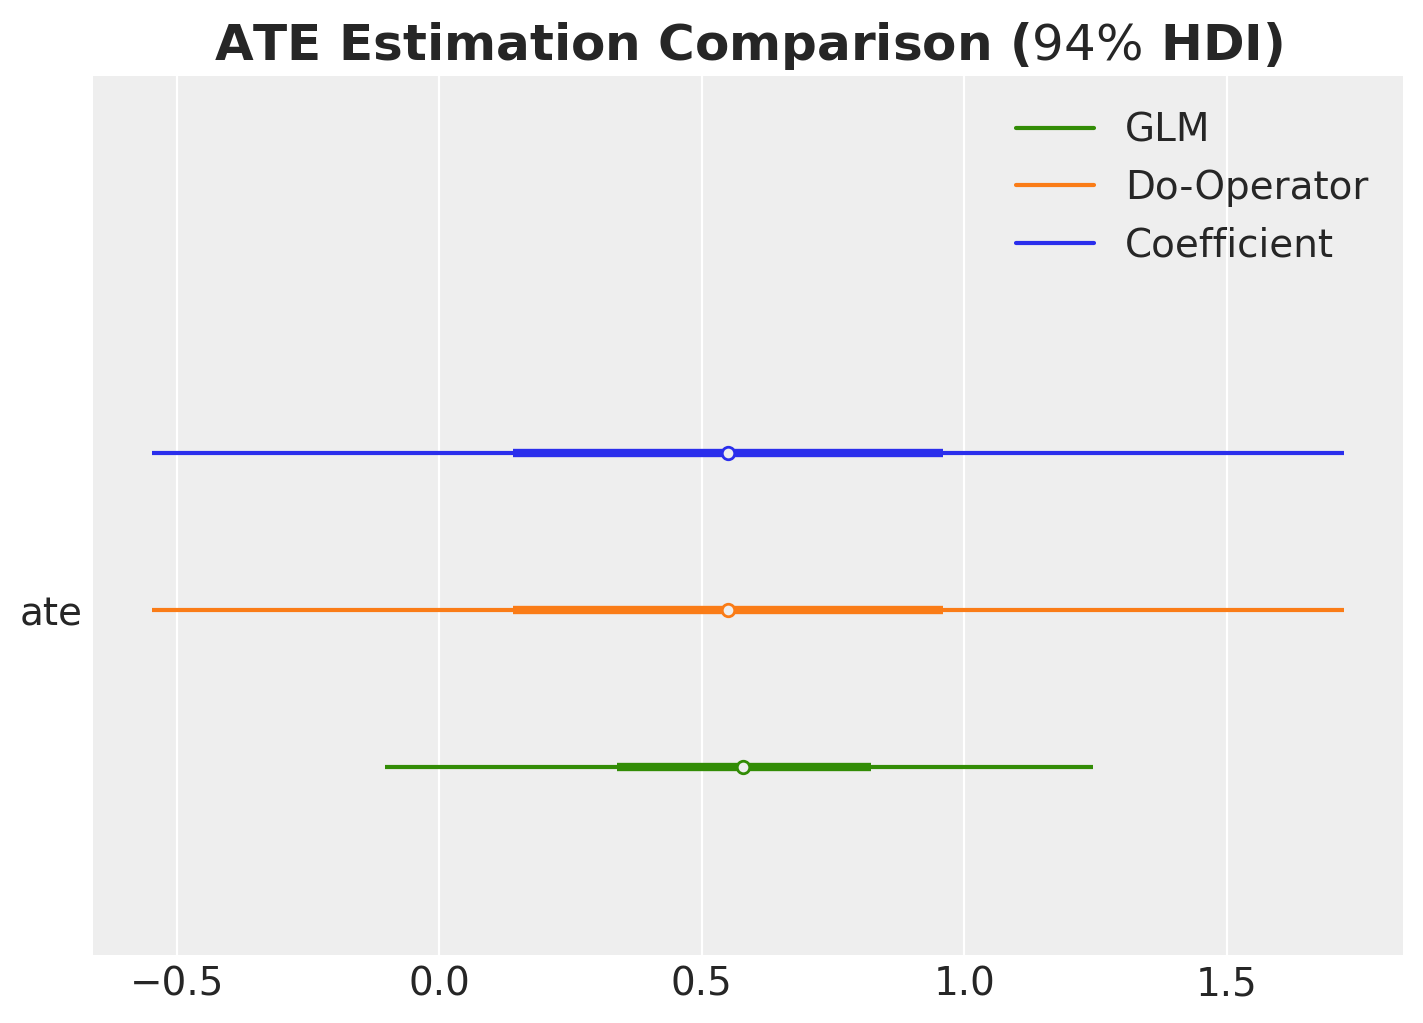

In [38]:
ax, *_ = az.plot_forest(
    data=[
        idata["posterior"].rename({"beta_treat_earnings": "ate"})["ate"],
        ate,
        glm_ate,
    ],
    model_names=["Coefficient", "Do-Operator", "GLM"],
    var_names=["ate"],
    combined=True,
    hdi_prob=0.94,
    figsize=(7, 5),
)
ax.set_title(r"ATE Estimation Comparison ($94\%$ HDI)", fontsize=18, fontweight="bold");

Finally, let's compare the models using leave-one-out cross-validation (LOO-CV).

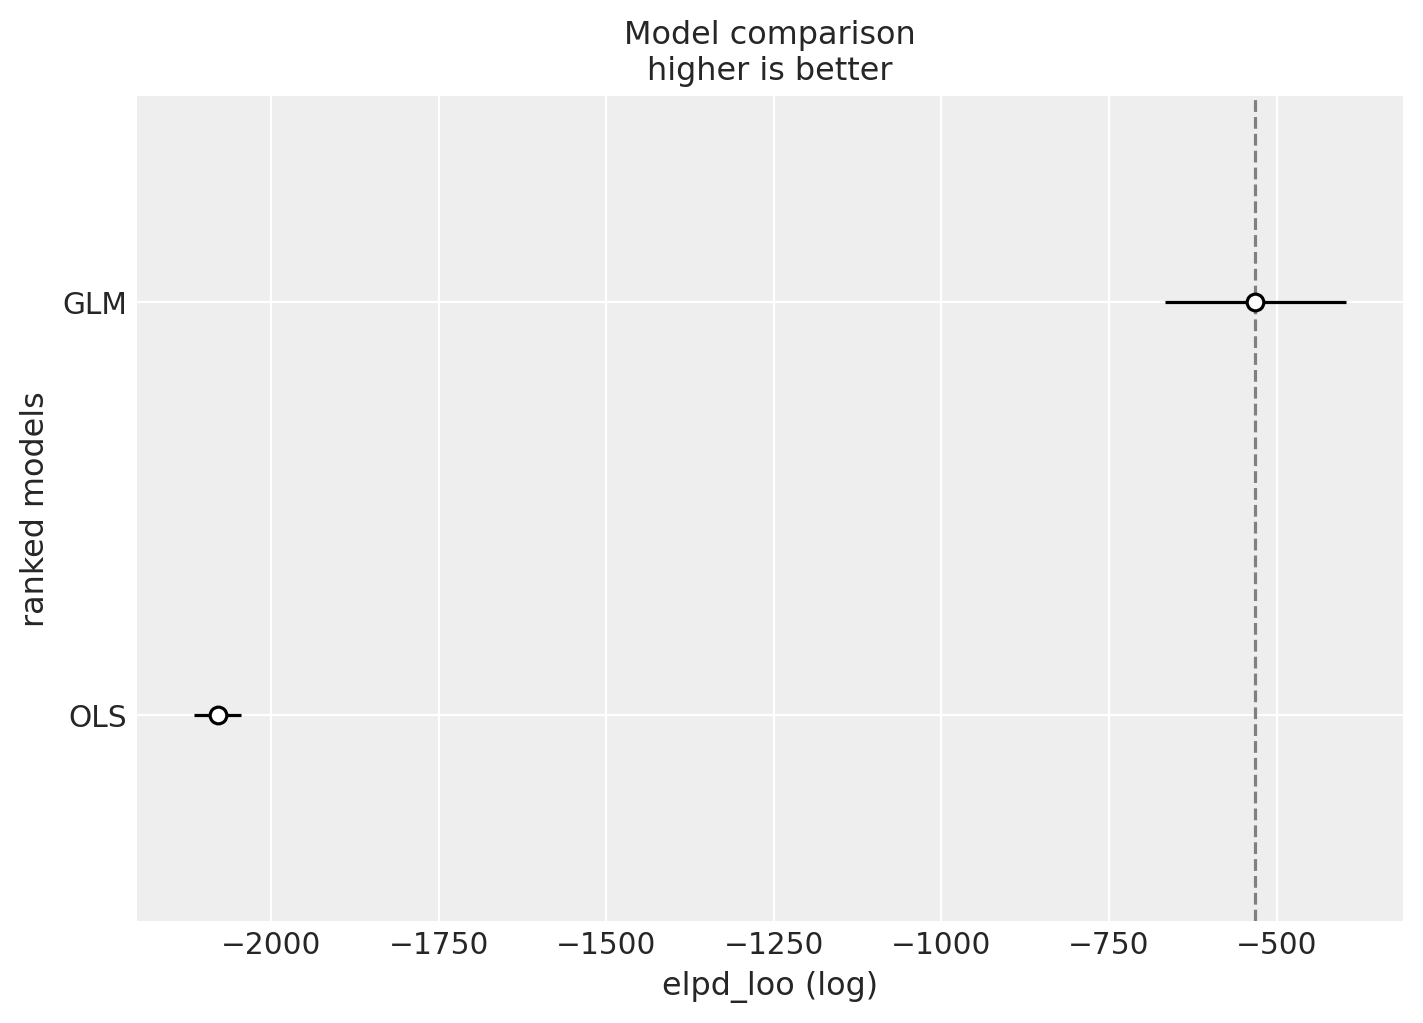

In [39]:
compare_df = az.compare(
    compare_dict={
        "OLS": idata,
        "GLM": glm_idata,
    },
    var_name="earnings",
    ic="loo",
)

az.plot_compare(compare_df, figsize=(7, 5));

As expected, the GLM model outperforms the OLS model, which makes sense given that it better
respects the domain constraints of the earnings outcome variable.

## Conclusion

In this notebook, we've explored how probabilistic programming languages, specifically PyMC,
provide a powerful and intuitive framework for causal inference. Through our analysis of the
Lalonde dataset, we've demonstrated several key principles:

### Key Takeaways

1. **Confounding matters**: The naive comparison of treated and untreated groups gave a misleading
   estimate of the treatment effect. By explicitly modeling confounders—variables that affect both
   treatment assignment and outcomes—we obtained more reliable causal estimates.

2. **Bayesian inference provides full uncertainty quantification**: Rather than just point estimates
   and confidence intervals, we obtained full posterior distributions for the Average Treatment
   Effect (ATE), giving us a richer understanding of uncertainty that accounts for all sources of
   variation.

3. **The `do` operator enables counterfactual reasoning**: By implementing Pearl's do-calculus
   directly in PyMC, we could answer "what if" questions—computing counterfactual outcomes under
   different treatment scenarios. This approach is more general than coefficient interpretation
   and works seamlessly with non-linear models.

4. **Model validation is essential**: Through prior predictive checks, convergence diagnostics,
   and posterior predictive checks, we ensured our models were well-specified and our inferences
   were reliable. The comparison between OLS and GLM models highlighted the importance of choosing
   appropriate likelihood functions that respect domain constraints.

### Why Use PPLs Over Traditional OLS methods for Causal Inference?

For most basic causal inference problems, you can use traditional OLS methods. They have nothing wrong anf you should always start with them.

However, when the problem is more complex, PPLs can offer several advantages:

1. **Flexibility for Complex Models**
  - Extending to non-linear models (e.g., GLMs with non-identity link functions)
    makes ATE interpretation complex. The treatment coefficient no longer directly represents
    the ATE, and computing counterfactuals becomes mathematically challenging.
  - We can use custom Double ML methods with PPLs: see [Double ML in Numpyro using scope](https://kylejcaron.github.io/posts/2025-04-01-scope-double-ml.html).
  - The `do` operator approach works identically for linear models, GLMs, hierarchical
    models, and even complex non-parametric models. You can use the same counterfactual reasoning
    framework regardless of model complexity.
      - Example [Pyro Example Using Neural Networks and a more complex DAG]: [Chapter 11, Part 2 - Bayesian Causal Graphical Inference Workflow](https://github.com/altdeep/causalML/blob/master/book/chapter%2011/Chapter_11_Bayesian_Causal_Graphical_Inference.ipynb) from the book [Causal AI](https://www.manning.com/books/causal-ai).


2. **Incorporating Prior Knowledge**
  - Traditional OLS methods, don't have a natural way to incorporate domain expertise or
    previous study results.
  - Bayesian framework naturally incorporates prior knowledge through prior distributions.
    This is especially valuable when you have small samples or want to combine evidence from
    multiple sources.
      - Here is an example to use a prior experiments to reduce variance of the ATE estimate through instrumental variables: [Experimentation, Non-Compliance and Instrumental Variables with PyMC](https://juanitorduz.github.io/iv_pymc/).
      - Example of Prior specification for A/B tests: [Prior Predictive Modeling in Bayesian AB Testing](https://juanitorduz.github.io/prior_predictive_ab_testing/) (and an indication on how to do Bayesian power analysis: [Introduction to Bayesian Power Analysis: Exclude a Null Value](https://juanitorduz.github.io/power_sample_size_exclude_null/)).
      - We can combnine this with methods like CUPED: [Bayesian CUPED & Sensitivity Analysis](https://juanitorduz.github.io/bayesian_cuped/).
  

3. **Model Calibration**
   - Using Bayesian models, you can calibrate models with additional likelihoods. This is especially useful when you have unobserved confounders (very common in marketing).
      - Example in Marketing Mix Modeling: [Unobserved Confounders, ROAS and Lift Tests in Media Mix Models](https://www.pymc-labs.com/blog-posts/mmm_roas_lift).
      - Example constraining a Gaussian Process: [Electricity Demand Forecast: Dynamic Time-Series Model with Prior Calibration](https://juanitorduz.github.io/electricity_forecast_with_priors/).


I you want to explore real applications at Delivery Hero (AdTech), check out the GitHub repository [https://github.com/deliveryhero/adtech-statistical-modeling](https://github.com/deliveryhero/adtech-statistical-modeling).


In [40]:
%reload_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 18 2025

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

matplotlib: 3.10.7
pandas    : 2.3.3
seaborn   : 0.13.2
sklearn   : 1.6.1
graphviz  : 0.21
pytensor  : 2.35.1
jaxtyping : 0.3.3
arviz     : 0.22.0
numpy     : 2.3.4
pymc      : 5.26.1

Watermark: 2.5.0

